# Dataset Preparation

In [ ]:
pip install ucimlrepo

In [ ]:
from datetime import date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
online_retail = fetch_ucirepo(id=352)

# Extract the table from online_retail.data.originals
dataset = online_retail.data.original

# Convert to a pandas DataFrame
import pandas as pd

df = pd.DataFrame(dataset)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Setup BigQuery connection

In [ ]:
import os
from google.cloud import storage

# Define your GCS bucket and the key file path
bucket_name = 'g2-finalproject'
key_file_path = 'Credential/vertex.json'
local_key_path = '/tmp/service-account-file.json'

# Initialize a client
storage_client = storage.Client()

# Download the key file from GCS
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob(key_file_path)
blob.download_to_filename(local_key_path)

# Set the environment variable
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = local_key_path

# Verify the environment variable is set correctly
print(f"GOOGLE_APPLICATION_CREDENTIALS is set to: {os.getenv('GOOGLE_APPLICATION_CREDENTIALS')}")

GOOGLE_APPLICATION_CREDENTIALS is set to: /tmp/service-account-file.json


In [ ]:
from google.colab import auth
from google.cloud import bigquery

# Create a BigQuery client
client = bigquery.Client(location="asia-southeast2")

In [ ]:
def run_query(query):
  query_job = client.query(query)  # Create an API request
  result = query_job.result() # Wait for the query to finish

  df_query = result.to_dataframe()
  return df_query

In [ ]:
query = """
SELECT *
FROM `finalproject-g2df12.retail.raw_dataiku`
LIMIT 10
"""

run_query(query)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536414,22139,None,56,12/1/10 11:52,0,None,United Kingdom
1,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/10 14:32,2.51,None,United Kingdom
2,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,12/1/10 14:32,2.51,None,United Kingdom
3,536544,21809,CHRISTMAS HANGING TREE WITH BELL,1,12/1/10 14:32,2.51,None,United Kingdom
4,536544,21822,GLITTER CHRISTMAS TREE WITH BELLS,1,12/1/10 14:32,4.21,None,United Kingdom
5,536544,21870,I CAN ONLY PLEASE ONE PERSON MUG,1,12/1/10 14:32,3.36,None,United Kingdom
6,536544,21884,CAKES AND BOWS GIFT TAPE,1,12/1/10 14:32,1.66,None,United Kingdom
7,536544,21894,POTTING SHED SEED ENVELOPES,1,12/1/10 14:32,2.51,None,United Kingdom
8,536544,21914,BLUE HARMONICA IN BOX,3,12/1/10 14:32,2.51,None,United Kingdom
9,536544,21935,SUKI SHOULDER BAG,1,12/1/10 14:32,3.36,None,United Kingdom


# Ingest DataFrame to GCS and BigQuery

In [ ]:
# Export DataFrame to CSV
csv_file_path = '/tmp/raw_data.csv'
df.to_csv(csv_file_path, index=False)

# Upload the CSV file to GCS
bucket = storage_client.bucket(bucket_name)
blob = bucket.blob('Data/raw_data.csv')
blob.upload_from_filename(csv_file_path)

print(f"CSV file uploaded to: gs://{bucket_name}/{blob.name}")

CSV file uploaded to: gs://g2-finalproject/Data/raw_data.csv


In [ ]:
from google.cloud import bigquery

# Initialize a client
storage_client = storage.Client()
bigquery_client = bigquery.Client()

# Define project and dataset ID
project_id = 'finalproject-g2df12'
dataset_id = 'retail'
table = 'raw_data'

# Define the destination table
table_id = f'{project_id}.{dataset_id}.{table}'
csv_uri = f'gs://g2-finalproject/Data/raw_data.csv'

# Define schema
schema = [
    bigquery.SchemaField('InvoiceNo', 'STRING'),
    bigquery.SchemaField('StockCode', 'STRING'),
    bigquery.SchemaField('Description', 'STRING'),
    bigquery.SchemaField('Quantity', 'INTEGER'),
    bigquery.SchemaField('InvoiceDate', 'STRING'),
    bigquery.SchemaField('UnitPrice', 'FLOAT'),
    bigquery.SchemaField('CustomerID', 'FLOAT'),
    bigquery.SchemaField('Country', 'STRING')
]

# Load CSV data into BigQuery
job_config = bigquery.LoadJobConfig(
    schema=schema,
    skip_leading_rows=1,
    source_format=bigquery.SourceFormat.CSV
)
job = bigquery_client.load_table_from_uri(
    csv_uri,
    table_id,
    job_config=job_config
)

job.result()  # Waits for the job to complete.

table = bigquery_client.get_table(table_id)  # Make an API request.

In [ ]:
from google.cloud import bigquery
from google.colab import auth

# Create BigQuery client
client = bigquery.Client()

dataset_id = 'clv'
table_id = 'raw'
project_id = 'finalproject-g2df12'

from pandas_gbq import to_gbq

to_gbq(
    df,
    f'{dataset_id}.{table_id}',
    project_id=project_id,
    if_exists='replace'  # Options: 'fail', 'replace', 'append'
)

100%|██████████| 1/1 [00:00<00:00, 7436.71it/s]


# EDA with SQL

Urutan data preprocessingnya:
1. Rename column:
  - InvoiceID = transaction_id
  - StockCode = product_id
  - Description = product_name
  - Quantity = product_quantity
  - InvoiceDate = transaction_date
  - UnitPrice = price
  - CustomerID = customer_id
  - Country = customer_country

2. Ubah format `transaction_date` jadi DATETIME.

3. Ekstrak `transaction_date` untuk nambahin columns `year`, `month`, `day of week`, sama `week of year`.

4. Untuk column `transaction_id`, remove semua data yg depannya ada C nya. Itu cancelled transaction.

5. Untuk column `product_id`, ambil 5 digit pertama tanpa letter.

6. Untuk `customer_id`, semua missing value diisi 99999 aja.

7. Untuk `product_name`, missing value diisi modus (coba pakai join SQL).

8. Untuk `purchase_price`, yg nilainya 0 atau negatif di ganti pakai modus.

9. Untuk `product_quantity`, yg nilainya negatif di drop aja.

10. Untuk `customer_country`, ganti sesuai ini:
  - EIRE = Ireland
  - Channel Island = United Kingdom
  - RSA = South Africa

In [ ]:
query = """
SELECT

FROM
  `finalproject-g2df12.retail.raw_dataiku`
"""

run_query(query)

,StockCode
0,22139
1,22139
2,21134
3,22145
4,37509
...,...
1989,85175
1990,85175
1991,85175
1992,85175


# EDA with Python

## Data Preprocessing

In [ ]:
# Copy df to df_cleaned
df_cleaned = df.copy()

In [ ]:
# Summary statistics
df_cleaned.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


### Check missing values

In [ ]:
# Check for missing values
missing_values = df_cleaned.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [ ]:
# Check rows with missing values
df_cleaned[df_cleaned.isnull().any(axis=1)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


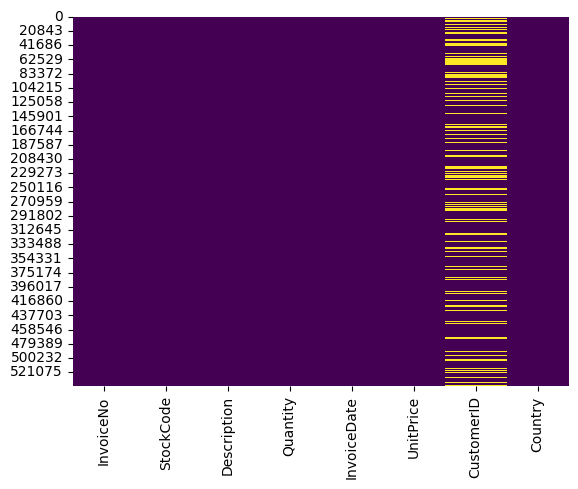

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_cleaned.isnull(), cbar=False, cmap='viridis')
plt.show()

In [ ]:
# Data check based on Data Catalog
print('Check if we had negative quantity and prices at same register:',
     'No' if df_cleaned[(df_cleaned.Quantity<0) & (df_cleaned.UnitPrice<0)].shape[0] == 0 else 'Yes', '\n')

print('Check how many register we have where quantity is negative',
      'and prices is 0 or vice-versa:',
      df_cleaned[(df_cleaned.Quantity<=0) & (df_cleaned.UnitPrice<=0)].shape[0])

print('\n% Negative Quantity: {:3.2%}'.format(df_cleaned[(df_cleaned.Quantity<0)].shape[0]/df_cleaned.shape[0]))

print('% Zero Quantity: {:3.2%}'.format(df_cleaned[(df_cleaned.Quantity==0)].shape[0]/df_cleaned.shape[0]))

print('\n% Negative Unit Price: {:3.2%}'.format(df_cleaned[(df_cleaned.UnitPrice<0)].shape[0]/df_cleaned.shape[0]))

print('% Zero Unit Price: {:3.2%}'.format(df_cleaned[(df_cleaned.UnitPrice==0)].shape[0]/df_cleaned.shape[0]))

print('\nAll register with negative quantity has Invoice start with:',
      df_cleaned.loc[(df_cleaned.Quantity<0) & ~(df_cleaned.CustomerID.isnull()), 'InvoiceNo'].apply(lambda x: x[0]).unique())

print('\nCancelled registed with InvoiceID started with C: ',
      )

Check if we had negative quantity and prices at same register: No 

Check how many register we have where quantity is negative and prices is 0 or vice-versa: 1336

% Negative Quantity: 1.96%
% Zero Quantity: 0.00%

% Negative Unit Price: 0.00%
% Zero Unit Price: 0.46%

All register with negative quantity has Invoice start with: ['C']

Cancelled registed with InvoiceID started with C: 


In [ ]:
print('Check register with UnitPrice negative:')
display(df_cleaned[(df_cleaned.UnitPrice<0)])

print("Sales records with Customer ID and zero in Unit Price:",df_cleaned[(df_cleaned.UnitPrice==0)  & ~(df_cleaned.CustomerID.isnull())].shape[0])
df_cleaned[(df_cleaned.UnitPrice==0)  & ~(df_cleaned.CustomerID.isnull())]

Check register with UnitPrice negative:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


Sales records with Customer ID and zero in Unit Price: 40


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1,12/5/2010 14:02,0.0,12647.0,Germany
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4,12/16/2010 14:36,0.0,16560.0,United Kingdom
40089,539722,22423,REGENCY CAKESTAND 3 TIER,10,12/21/2010 13:45,0.0,14911.0,EIRE
47068,540372,22090,PAPER BUNTING RETROSPOT,24,1/6/2011 16:41,0.0,13081.0,United Kingdom
47070,540372,22553,PLASTERS IN TIN SKULLS,24,1/6/2011 16:41,0.0,13081.0,United Kingdom
56674,541109,22168,ORGANISER WOOD ANTIQUE WHITE,1,1/13/2011 15:10,0.0,15107.0,United Kingdom
86789,543599,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,16,2/10/2011 13:08,0.0,17560.0,United Kingdom
130188,547417,22062,CERAMIC BOWL WITH LOVE HEART DESIGN,36,3/23/2011 10:25,0.0,13239.0,United Kingdom
139453,548318,22055,MINI CAKE STAND HANGING STRAWBERY,5,3/30/2011 12:45,0.0,13113.0,United Kingdom
145208,548871,22162,HEART GARLAND RUSTIC PADDED,2,4/4/2011 14:42,0.0,14410.0,United Kingdom


### Cleaning

In [ ]:
# Data types
print(df_cleaned.dtypes)

# Unique values
for column in df_cleaned.columns:
    print(f"{column}: {df_cleaned[column].nunique()} unique values")

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
InvoiceNo: 25900 unique values
StockCode: 4070 unique values
Description: 4223 unique values
Quantity: 722 unique values
InvoiceDate: 23260 unique values
UnitPrice: 1630 unique values
CustomerID: 4372 unique values
Country: 38 unique values


Customer ID: Unique identifiers for customers. <br>
Invoice No: Transaction identifiers. <br>
StockCode: Product codes. <br>
Description: Descriptions of products. <br>
Quantity: Number of products. <br>
InvoiceDate: Dates of transactions. <br>
UnitPrice: Prices of products. <br>
Country: Countries where transactions were made.

#### Convert time and extract to week of year and day of month

In [ ]:
# Convert InvoiceDate to datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

df_cleaned.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [ ]:
# Extract Date Part
df_cleaned['Year'] = df_cleaned['InvoiceDate'].dt.year
df_cleaned['Month'] = df_cleaned['InvoiceDate'].dt.month
df_cleaned['Day'] = df_cleaned['InvoiceDate'].dt.day
df_cleaned['DayOfWeek'] = df_cleaned['InvoiceDate'].dt.dayofweek
df_cleaned['WeekOfYear'] = df_cleaned['InvoiceDate'].dt.isocalendar().week

df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,2,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,2,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48


In [ ]:
df_cleaned['WeekOfYear'] = df_cleaned['WeekOfYear'].astype('int64')

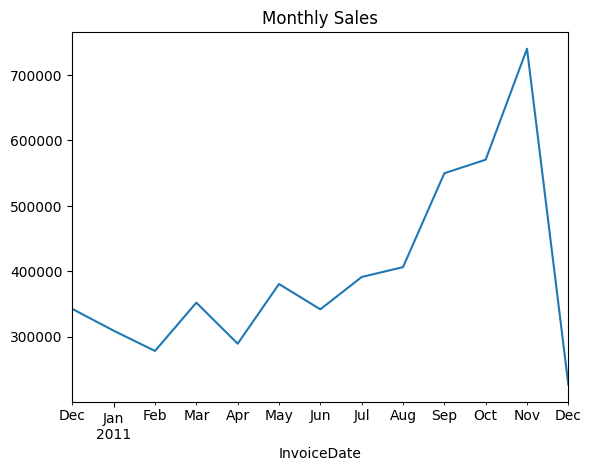

In [ ]:
# Transactions over time
df_cleaned.set_index('InvoiceDate')['Quantity'].resample('M').sum().plot()
plt.title('Monthly Sales')
plt.show()

#### Clean InvoiceNo column

In [ ]:
# Filter rows where length of 'InvoiceNo' is greater than 6
invoices_with_more_than_6_chars = df_cleaned[df_cleaned['InvoiceNo'].str.len() > 6]

# Filter rows where 'InvoiceNo' starts with 'c'
canceled_invoices = df_cleaned[df_cleaned['InvoiceNo'].str.startswith('C', na=False)]

print("\nNumber of canceled invoices:", canceled_invoices.shape[0])
print("\nNumber of invoices with more than 6 chars:", invoices_with_more_than_6_chars.shape[0])


Number of canceled invoices: 9288

Number of invoices with more than 6 chars: 9291


In [ ]:
canceled_invoices.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,2010,12,1,2,48
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,2010,12,1,2,48
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,2010,12,1,2,48
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,2,48
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,2010,12,1,2,48


In [ ]:
# Filter rows where length of 'InvoiceNo' is greater than 6 and 'InvoiceNo' does not start with 'C' or 'c'
invoices_with_more_than_6_chars_not_start_with_c = df_cleaned[
    (df_cleaned['InvoiceNo'].str.len() > 6) &
    (~df_cleaned['InvoiceNo'].str.startswith(('C', 'c')))
]

# Display the rows with 'InvoiceNo' that have more than 6 characters but do not start with 'C' or 'c'
print("Rows with 'InvoiceNo' that have more than 6 characters but do not start with 'C' or 'c':")
invoices_with_more_than_6_chars_not_start_with_c

Rows with 'InvoiceNo' that have more than 6 characters but do not start with 'C' or 'c':


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
299982,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,NaN,United Kingdom,2011,8,12,4,32
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,2011,8,12,4,32
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,2011,8,12,4,32


In [ ]:
# Filter rows where length of 'InvoiceNo' is 6 or fewer characters
df_cleaned = df_cleaned[df_cleaned['InvoiceNo'].str.len() <= 6]

df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010,12,1,2,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010,12,1,2,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010,12,1,2,48


In [ ]:
# Count number of row before and after dropping invalid InvoiceID
print("Number of rows before dropping invalid InvoiceID:", df.shape[0])
print("Number of rows after dropping invalid InvoiceID:", df_cleaned.shape[0])
print("Number of dropped rows:", df.shape[0] - df_cleaned.shape[0])

Number of rows before dropping invalid InvoiceID: 541909
Number of rows after dropping invalid InvoiceID: 532618
Number of dropped rows: 9291


#### Clean StockCode column

In [ ]:
# Filter rows where length of 'StockCode' is greater than 5 from the cleaned dataframe
stock_code_more_than_5_chars = df_cleaned[df_cleaned['StockCode'].str.len() > 5]

print("Number of stock code with more than 5 chars:", stock_code_more_than_5_chars.shape[0])

Number of stock code with more than 5 chars: 51318


In [ ]:
# Remove any non-digit characters from the 'StockCode' column
df_cleaned.loc[:, 'StockCode'] = df_cleaned['StockCode'].str.replace(r'\D', '')

# Keep only the first 5 characters in case the resulting string is longer
df_cleaned.loc[:, 'StockCode'] = df_cleaned['StockCode'].str[:5]

# Filter rows where length of 'StockCode' is greater than 5 from the cleaned dataframe
stock_code_more_than_5_chars = df_cleaned[df_cleaned['StockCode'].str.len() > 5]

print("Number of stock code with more than 5 chars:", stock_code_more_than_5_chars.shape[0])

Number of stock code with more than 5 chars: 0


#### Clean CustomerID

In [ ]:
# Check for outliers (IDs outside the expected 5-digit range)
outliers = df_cleaned[(df_cleaned['CustomerID'] < 10000) | (df_cleaned['CustomerID'] > 99999)]
if not outliers.empty:
    print("Outliers found:")
    print(outliers)
else:
    print("No outliers found")

No outliers found


In [ ]:
# Calculate number and percentage of missing value in CustomerID
print("Number of missing values:", df_cleaned['CustomerID'].isnull().sum())
print("Percentage of missing values: {:.2%}".format(df_cleaned['CustomerID'].isnull().sum()/df_cleaned.shape[0]))

Number of missing values: 134694
Percentage of missing values: 25.29%


Because the percentage of missing value in CustomerID is pretty high, I want to fill the missing value of the CustomerID with 99999 instead so we don't need to drop the row but can identify that CustomerID 99999 is an invalid customer.

In [ ]:
# Fill missing values with a 99999
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].fillna(99999)

# Calculate number and percentage of missing value in CustomerID
print("Number of missing values:", df_cleaned['CustomerID'].isnull().sum())
print("Percentage of missing values: {:.2%}".format(df_cleaned['CustomerID'].isnull().sum()/df_cleaned.shape[0]))

Number of missing values: 0
Percentage of missing values: 0.00%


In [ ]:
# Converting to integer
df_cleaned['CustomerID'] = df_cleaned['CustomerID'].astype(int)

df_cleaned.dtypes
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,48
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,48
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48


In [ ]:
df_cleaned.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
Year              0
Month             0
Day               0
DayOfWeek         0
WeekOfYear        0
dtype: int64

#### Missing values in Description

In [ ]:
# Drop rows where Description is missing to create the mapping
stock_description_map = df_cleaned.dropna(subset=['Description']).drop_duplicates(subset=['StockCode'])

# Create a mapping of StockCode to Description
stock_description_map = stock_description_map.set_index('StockCode')['Description'].to_dict()

stock_description_map

{'85123': 'WHITE HANGING HEART T-LIGHT HOLDER',
 '71053': 'WHITE METAL LANTERN',
 '84406': 'CREAM CUPID HEARTS COAT HANGER',
 '84029': 'KNITTED UNION FLAG HOT WATER BOTTLE',
 '22752': 'SET 7 BABUSHKA NESTING BOXES',
 '21730': 'GLASS STAR FROSTED T-LIGHT HOLDER',
 '22633': 'HAND WARMER UNION JACK',
 '22632': 'HAND WARMER RED POLKA DOT',
 '84879': 'ASSORTED COLOUR BIRD ORNAMENT',
 '22745': "POPPY'S PLAYHOUSE BEDROOM ",
 '22748': "POPPY'S PLAYHOUSE KITCHEN",
 '22749': 'FELTCRAFT PRINCESS CHARLOTTE DOLL',
 '22310': 'IVORY KNITTED MUG COSY ',
 '84969': 'BOX OF 6 ASSORTED COLOUR TEASPOONS',
 '22623': 'BOX OF VINTAGE JIGSAW BLOCKS ',
 '22622': 'BOX OF VINTAGE ALPHABET BLOCKS',
 '21754': 'HOME BUILDING BLOCK WORD',
 '21755': 'LOVE BUILDING BLOCK WORD',
 '21777': 'RECIPE BOX WITH METAL HEART',
 '48187': 'DOORMAT NEW ENGLAND',
 '22960': 'JAM MAKING SET WITH JARS',
 '22913': 'RED COAT RACK PARIS FASHION',
 '22912': 'YELLOW COAT RACK PARIS FASHION',
 '22914': 'BLUE COAT RACK PARIS FASHION',
 '2175

In [ ]:
# Define a function to fill missing descriptions
def fill_description(row):
  if pd.isnull(row['Description']):
    return stock_description_map.get(row['StockCode'], row['Description'])
  return row['Description']

# Apply the function to the DataFrame
df_cleaned['Description'] = df.apply(fill_description, axis=1)

df_cleaned.isnull().sum()

InvoiceNo        0
StockCode        0
Description    468
Quantity         0
InvoiceDate      0
UnitPrice        0
CustomerID       0
Country          0
Year             0
Month            0
Day              0
DayOfWeek        0
WeekOfYear       0
dtype: int64

In [ ]:
missing_description = df_cleaned[df_cleaned['Description'].isnull() & (df_cleaned['CustomerID'] == 99999)]

print('Total missing description value with customer ID 99999:', missing_description.shape[0])

Total missing description value with customer ID 99999: 468


In [ ]:
df_cleaned = df_cleaned.dropna(subset=['Description'])

df_cleaned.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Year           0
Month          0
Day            0
DayOfWeek      0
WeekOfYear     0
dtype: int64

I think we can drop rows with invalid customer (ID = 99999) and missing product description.

In [ ]:
print("Percentage data used compared to raw: {:.2%}\n".format(df_cleaned.shape[0]/df.shape[0]))
df_cleaned.info()

Percentage data used compared to raw: 98.20%

<class 'pandas.core.frame.DataFrame'>
Index: 532150 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    532150 non-null  object        
 1   StockCode    532150 non-null  object        
 2   Description  532150 non-null  object        
 3   Quantity     532150 non-null  int64         
 4   InvoiceDate  532150 non-null  datetime64[ns]
 5   UnitPrice    532150 non-null  float64       
 6   CustomerID   532150 non-null  int64         
 7   Country      532150 non-null  object        
 8   Year         532150 non-null  int32         
 9   Month        532150 non-null  int32         
 10  Day          532150 non-null  int32         
 11  DayOfWeek    532150 non-null  int32         
 12  WeekOfYear   532150 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(4), int64(3), object(4)
memory usage: 48.7+ MB


In [ ]:
df_cleaned.describe().round(2)

,Quantity,InvoiceDate,UnitPrice,CustomerID,Year,Month,Day,DayOfWeek,WeekOfYear
count,532150.00,532150,532150.00,532150.00,532150.00,532150.00,532150.00,532150.00,532150.00
mean,10.25,2011-07-04 18:16:27.086986496,3.87,36659.67,2010.92,7.56,15.03,2.44,30.76
min,-9600.00,2010-12-01 08:26:00,0.00,12346.00,2010.00,1.00,1.00,0.00,1.00
25%,1.00,2011-03-28 12:13:00,1.25,14390.00,2011.00,5.00,7.00,1.00,18.00
50%,3.00,2011-07-20 12:01:00,2.08,16283.00,2011.00,8.00,15.00,2.00,34.00
75%,10.00,2011-10-19 12:35:00,4.13,99999.00,2011.00,11.00,22.00,4.00,45.00
max,80995.00,2011-12-09 12:50:00,13541.33,99999.00,2011.00,12.00,31.00,6.00,51.00
std,159.59,NaN,32.48,36816.63,0.27,3.51,8.66,1.85,15.14


#### Negative value in UnitPrice

In [ ]:
df_cleaned[(df_cleaned['UnitPrice']<=0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
622,536414,22139,RETROSPOT TEA SET CERAMIC 11 PC,56,2010-12-01 11:52:00,0.0,99999,United Kingdom,2010,12,1,2,48
1971,536546,22145,CHRISTMAS CRAFT HEART STOCKING,1,2010-12-01 14:33:00,0.0,99999,United Kingdom,2010,12,1,2,48
1972,536547,37509,NEW ENGLAND MUG W GIFT BOX,1,2010-12-01 14:33:00,0.0,99999,United Kingdom,2010,12,1,2,48
2025,536553,37461,FUNKY MONKEY MUG,3,2010-12-01 14:35:00,0.0,99999,United Kingdom,2010,12,1,2,48
2406,536589,21777,RECIPE BOX WITH METAL HEART,-10,2010-12-01 16:50:00,0.0,99999,United Kingdom,2010,12,1,2,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
536981,581234,72817,SET OF 2 CHRISTMAS DECOUPAGE CANDLE,27,2011-12-08 10:33:00,0.0,99999,United Kingdom,2011,12,8,3,49
538504,581406,46000,POLYESTER FILLER PAD 45x45cm,240,2011-12-08 13:58:00,0.0,99999,United Kingdom,2011,12,8,3,49
538505,581406,46000,POLYESTER FILLER PAD 40x40cm,300,2011-12-08 13:58:00,0.0,99999,United Kingdom,2011,12,8,3,49
538554,581408,85175,CACTI T-LIGHT CANDLES,20,2011-12-08 14:06:00,0.0,99999,United Kingdom,2011,12,8,3,49


In [ ]:
# Replace zero and negative values with null
df_cleaned['UnitPrice'] = df_cleaned['UnitPrice'].apply(lambda x: None if x <= 0 else x)

# Fill null values in UnitPrice with mode based on StockCode
def fill_with_mode(x):
    mode_values = x.mode()
    if len(mode_values) > 0:  # Check if mode exists
        return x.fillna(mode_values[0])
    else:
        return x  # If no mode exists, return original values

df_cleaned['UnitPrice'] = df_cleaned.groupby('StockCode')['UnitPrice'].transform(fill_with_mode)

df_cleaned.isnull().sum()

InvoiceNo       0
StockCode       0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice      13
CustomerID      0
Country         0
Year            0
Month           0
Day             0
DayOfWeek       0
WeekOfYear      0
dtype: int64

In [ ]:
df_cleaned = df_cleaned.dropna(subset=['UnitPrice'])

df_cleaned.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Year           0
Month          0
Day            0
DayOfWeek      0
WeekOfYear     0
dtype: int64

#### Negative value in Quantity

In [ ]:
df_cleaned[df_cleaned['Quantity']<=0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
2406,536589,21777,RECIPE BOX WITH METAL HEART,-10,2010-12-01 16:50:00,7.95,99999,United Kingdom,2010,12,1,2,48
7188,536996,22712,CARD DOLLY GIRL,-20,2010-12-03 15:30:00,0.42,99999,United Kingdom,2010,12,3,4,48
7189,536997,22028,PENNY FARTHING BIRTHDAY CARD,-20,2010-12-03 15:30:00,0.42,99999,United Kingdom,2010,12,3,4,48
7190,536998,85067,CREAM SWEETHEART WALL CABINET,-6,2010-12-03 15:30:00,18.95,99999,United Kingdom,2010,12,3,4,48
7192,537000,21414,SCALLOP SHELL SOAP DISH,-22,2010-12-03 15:32:00,2.10,99999,United Kingdom,2010,12,3,4,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,3.75,99999,United Kingdom,2011,12,7,2,49
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.29,99999,United Kingdom,2011,12,7,2,49
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.85,99999,United Kingdom,2011,12,7,2,49
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.83,99999,United Kingdom,2011,12,8,3,49


In [ ]:
# Replace zero and negative values with null
df_cleaned['Quantity'] = df_cleaned['Quantity'].apply(lambda x: None if x <= 0 else x)

df_cleaned.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity       1007
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
Year              0
Month             0
Day               0
DayOfWeek         0
WeekOfYear        0
dtype: int64

In [ ]:
df_cleaned = df_cleaned.dropna(subset=['Quantity'])

df_cleaned.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
Year           0
Month          0
Day            0
DayOfWeek      0
WeekOfYear     0
dtype: int64

In [ ]:
print("Percentage data used compared to raw: {:.2%}\n".format(df_cleaned.shape[0]/df.shape[0]))
df_cleaned.info()

Percentage data used compared to raw: 98.01%

<class 'pandas.core.frame.DataFrame'>
Index: 531130 entries, 0 to 541908
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    531130 non-null  object        
 1   StockCode    531130 non-null  object        
 2   Description  531130 non-null  object        
 3   Quantity     531130 non-null  float64       
 4   InvoiceDate  531130 non-null  datetime64[ns]
 5   UnitPrice    531130 non-null  float64       
 6   CustomerID   531130 non-null  int64         
 7   Country      531130 non-null  object        
 8   Year         531130 non-null  int32         
 9   Month        531130 non-null  int32         
 10  Day          531130 non-null  int32         
 11  DayOfWeek    531130 non-null  int32         
 12  WeekOfYear   531130 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(2), object(4)
memory usage: 48.6+ MB


### Country exploration

In [ ]:
# Check number of each country
df_cleaned['Country'].value_counts()

Country
United Kingdom          486131
Germany                   9042
France                    8408
EIRE                      7894
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1967
Portugal                  1501
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Unspecified                446
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     295
Hong Kong                  284
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58


In [ ]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850,United Kingdom,2010,12,1,2,48
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850,United Kingdom,2010,12,1,2,48
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850,United Kingdom,2010,12,1,2,48


In [ ]:
df_cleaned.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity              float64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
Year                    int32
Month                   int32
Day                     int32
DayOfWeek               int32
WeekOfYear              int64
dtype: object

In [ ]:
from google.cloud import bigquery
import pandas as pd
from pandas_gbq import to_gbq

# Initialize the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

# Dataset and table details
dataset_id = 'retail'
table_id = 'transaction_cleaned'
table_full_id = f"{project_id}.{dataset_id}.{table_id}"

# Create the dataset if it doesn't exist
dataset_ref = client.dataset(dataset_id)
try:
    client.get_dataset(dataset_ref)
    print(f"Dataset {dataset_id} already exists.")
except NotFound:
    dataset = bigquery.Dataset(dataset_ref)
    dataset = client.create_dataset(dataset)
    print(f"Created dataset {dataset_id}.")

# Upload the DataFrame to BigQuery
to_gbq(df_cleaned, table_full_id, project_id=project_id, if_exists='replace')

Dataset retail already exists.


KeyboardInterrupt: 

# RFM Segmentation

- **Low Value**: Customers who are less active than others, not very frequent buyer/visitor and generates very low to zero to negative revenue.
- **Mid Value**: Often using the platform, fairly frequent and generates moderate revenue.
- **High Value**: The group we don't want to lose. High revenue, frequency, and low inactivity.

In [ ]:
# Set up the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

# Load data from BigQuery
query = """
SELECT *
FROM `finalproject-g2df12.retail.transaction_cleaned`
"""

# Load data into a DataFrame
df_cleaned = client.query(query).to_dataframe()

## Recency

Most recent purchase date of each customer and see how many days they are inactive for. Then apply K-means clustering to assign customers a recency score.

In [ ]:
# Create a user dataframe to keep CustomerID and new segmentation score
tx_user = pd.DataFrame(df_cleaned['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

,CustomerID
0,12431
1,12791
2,12433
3,13520
4,12557


Calculate the last date of transaction for a person.

In [ ]:
# Find the latest purchase date for each customer
tx_max_purchase = df_cleaned.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346,2011-01-18 10:01:00+00:00
1,12347,2011-12-07 15:52:00+00:00
2,12348,2011-09-25 13:13:00+00:00
3,12349,2011-11-21 09:51:00+00:00
4,12350,2011-02-02 16:01:00+00:00


In [ ]:
# Compare the last transaction of the dataset, with last transaction dates of the individual CustomerID
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346,2011-01-18 10:01:00+00:00,325
1,12347,2011-12-07 15:52:00+00:00,1
2,12348,2011-09-25 13:13:00+00:00,74
3,12349,2011-11-21 09:51:00+00:00,18
4,12350,2011-02-02 16:01:00+00:00,309


In [ ]:
# Merge the dataframe to the new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

,CustomerID,Recency
0,12431,35
1,12791,373
2,12433,0
3,13520,58
4,12557,15


Apply K-means clustering to assign a recency score.

Using Elbow Method to tell the optimal cluster number for optimal inertia.

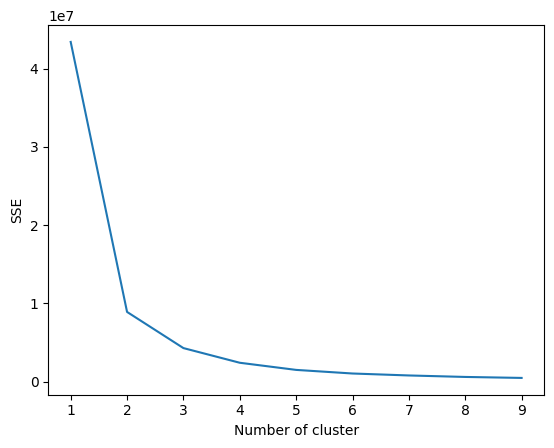

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

sse = {} # Empty dictionary to store the Sum of Squared Errors for different numbers of cluster
tx_recency = tx_user[['Recency']]

for k in range(1,10):
  kmeans = KMeans(n_clusters = k, max_iter = 1000, n_init=10).fit(tx_recency)
  tx_recency["clusters"] = kmeans.labels_
  sse[k] = kmeans.inertia_ # Store the inertia (SSE) which is a measure of how spread out the cluster are (the lower the better).

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

From the graph we can conclude that the "elbow" or the optimized cluster number is 3.

In [ ]:
# Build 4 cluster for recency
kmeans = KMeans(n_clusters = 4, n_init=10)
tx_user['RecencyCluster'] = kmeans.fit_predict(tx_user[['Recency']])+1

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,12431,35,1,236,0,6512.41,0,3,Low-Value
1,12557,15,1,33,0,11990.96,0,3,Low-Value
2,12779,37,1,149,0,3981.36,0,3,Low-Value
3,12395,18,1,156,0,3018.63,0,3,Low-Value
4,12808,36,1,28,0,483.65,0,3,Low-Value


In [ ]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,2250.0,19.880000,14.847881,0.0,7.0,17.0,30.0,52.0
1,497.0,307.983903,39.001289,251.0,274.0,304.0,336.0,373.0
2,995.0,84.606030,23.951358,53.0,64.0,78.0,103.0,138.0
3,598.0,192.503344,31.574683,139.0,165.0,190.0,217.0,250.0


The cluster is still in randomly assignmed. We need to give clusters according to most recent transactions.

First, need to find the mean of recency value corresponding to each cluster. Then sort the values.

From the above table:
cluster 3 > cluster 1 > cluster 0 > cluster 2
So we need to change accordingly:
- Cluster 3 -> Cluster 0
- Cluster 1 -> Cluster 1
- Cluster 0 -> Cluster 2
- Cluster 2 -> Cluster 3

In [ ]:
# Ordering cluster number
def order_cluster(cluster_field_name, target_field_name, data, ascending):
  new_cluster_field_name = 'new_' + cluster_field_name
  data_new = data.groupby(cluster_field_name)[target_field_name].mean().reset_index()
  data_new = data_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
  data_new['index'] = data_new.index
  data_final = pd.merge(data, data_new[[cluster_field_name, 'index']], on=cluster_field_name)
  data_final = data_final.drop([cluster_field_name], axis=1)
  data_final = data_final.rename(columns={"index": cluster_field_name})
  return data_final

In [ ]:
tx_user = order_cluster('RecencyCluster', 'Recency', tx_user, False)

tx_user.head()

,CustomerID,Recency,RecencyCluster
0,12431,35,3
1,12433,0,3
2,12557,15,3
3,12779,37,3
4,12395,18,3


In [ ]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,497.0,307.983903,39.001289,251.0,274.0,304.0,336.0,373.0
1,598.0,192.503344,31.574683,139.0,165.0,190.0,217.0,250.0
2,995.0,84.606030,23.951358,53.0,64.0,78.0,103.0,138.0
3,2250.0,19.880000,14.847881,0.0,7.0,17.0,30.0,52.0


   RecencyCluster  CustomerID     Recency
0               0         497  307.983903
1               1         598  192.503344
2               2         995   84.606030
3               3        2250   19.880000


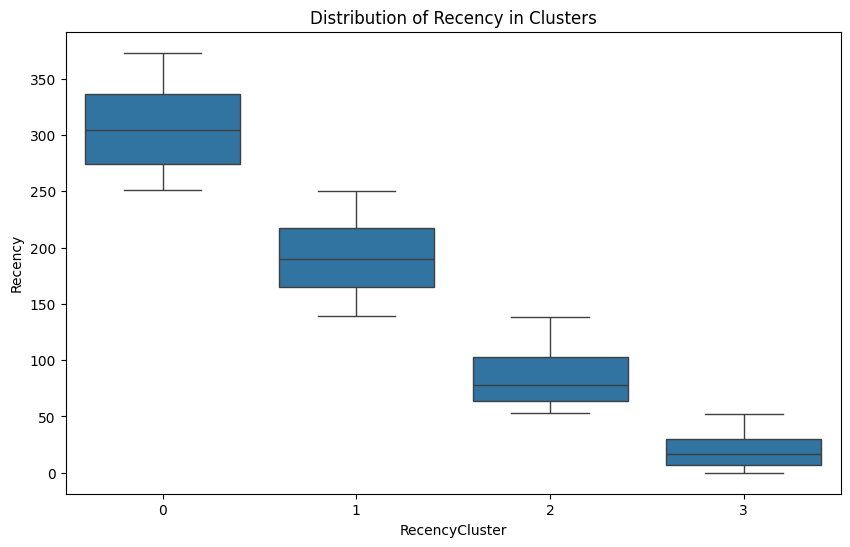

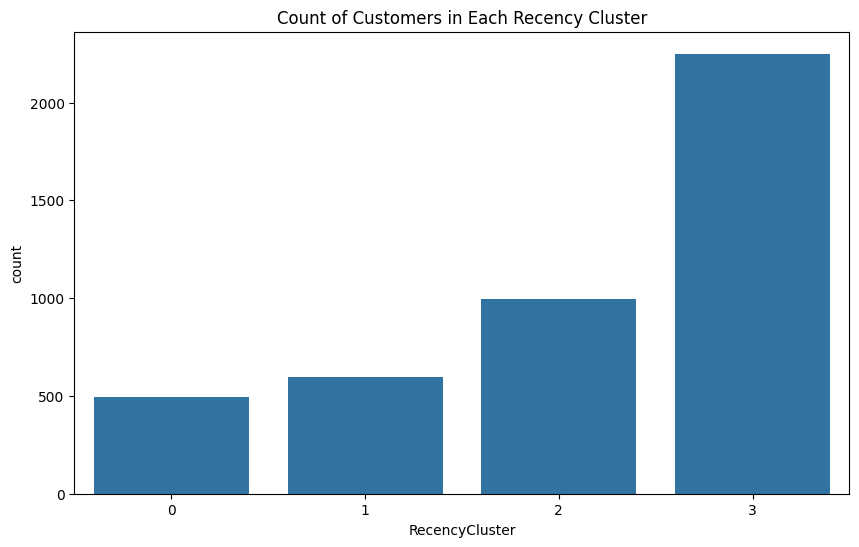

In [ ]:
# Profiling cluster
cluster_profile = tx_user.groupby('RecencyCluster').agg({
    'CustomerID': 'count',
    'Recency': 'mean',
}).reset_index()

print(cluster_profile)

# Visualisasi distribusi Recency dalam cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='RecencyCluster', y='Recency', data=tx_user)
plt.title('Distribution of Recency in Clusters')
plt.show()

# Visualisasi distribusi ukuran cluster
plt.figure(figsize=(10, 6))
sns.countplot(x='RecencyCluster', data=tx_user)
plt.title('Count of Customers in Each Recency Cluster')
plt.show()

## Frequency
We need to find total number orders for each customer.

In [ ]:
# Calculate total order for each user
tx_frequency = df_cleaned.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID', 'Frequency']

tx_frequency.describe()

,CustomerID,Frequency
count,4340.0,4340.000000
mean,15319.452765,122.380184
std,2148.767225,2033.506459
min,12346.0,1.000000
25%,13812.75,17.000000
50%,15299.5,41.000000
75%,16779.25,100.000000
max,99999.0,133206.000000


In [ ]:
# Add to tx_user table
tx_user = pd.merge(tx_user, tx_frequency, on=['CustomerID'])

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,12431,35,3,236
1,12433,0,3,420
2,12557,15,3,33
3,12779,37,3,149
4,12395,18,3,156


Determine the right number of clusters for K-Means by elbow method.

<ipython-input-57-90ff86ef2396>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-57-90ff86ef2396>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-57-90ff86ef2396>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-57-90ff86e

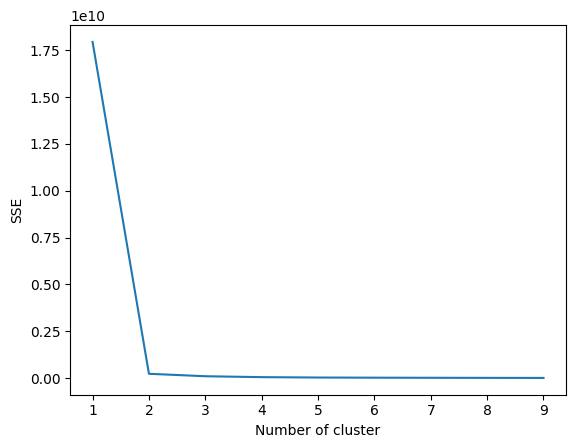

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

sse = {}
tx_frequency = tx_user[['Frequency']]

for k in range(1,10):
  kmeans = KMeans(n_clusters = k, max_iter = 1000, n_init=10).fit(tx_frequency)
  tx_frequency["clusters"] = kmeans.labels_
  sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [ ]:
# Apply K-Means with 4 cluster of frequency
kmeans = KMeans(n_clusters = 4, n_init=10)
tx_user['FrequencyCluster'] = kmeans.fit_predict(tx_user[['Frequency']])

# Order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency', tx_user, True)
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,4053.0,58.565014,58.408065,1.0,16.00,37.0,84.00,270.0
1,282.0,486.982270,315.213733,271.0,316.00,386.5,518.25,2700.0
2,4.0,5807.750000,1429.386203,4596.0,4982.25,5394.0,6219.50,7847.0
3,1.0,133206.000000,NaN,133206.0,133206.00,133206.0,133206.00,133206.0


In [ ]:
tx_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   CustomerID        4340 non-null   Int64
 1   Recency           4340 non-null   int64
 2   RecencyCluster    4340 non-null   int64
 3   Frequency         4340 non-null   int64
 4   FrequencyCluster  4340 non-null   int64
dtypes: Int64(1), int64(4)
memory usage: 173.9 KB


### Found an outlier!

I already calculate the Frequency for RFM but found an outliner in the frequency of order. I guess it is because of the CustomerID 99999.

Outlier problem fixed. Can ignore this part.

In [ ]:
# Check whether CustomerID 99999 is really an outlier
Q1 = tx_user['Frequency'].quantile(0.25)
Q3 = tx_user['Frequency'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = tx_user[(tx_user['Frequency'] < lower_bound) | (tx_user['Frequency'] > upper_bound)]

outliers

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster
0,12431,35,3,236,0
14,12583,2,3,247,0
21,12662,0,3,230,0
29,12476,15,3,233,0
36,16029,38,3,242,0
...,...,...,...,...,...
4335,99999,0,3,133206,3
4336,14911,0,3,5677,2
4337,12748,0,3,4596,2
4338,17841,1,3,7847,2


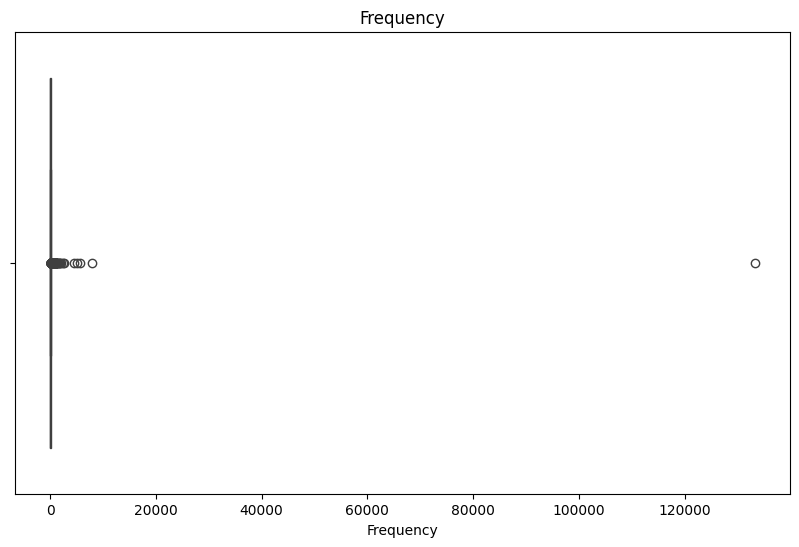

In [ ]:
plt.figure(figsize=(10, 6))
plt.title('Frequency')
sns.boxplot(x=tx_user['Frequency'])
plt.show()

Need to drop CustomerID 99999 and re-calculate the Recency.

In [ ]:
# Drop rows where CustomerID is 99999
print('Before dropping:\n', df_cleaned.shape[0])

df_cleaned = df_cleaned[df_cleaned['CustomerID'] != 99999]

print('After dropping:\n', df_cleaned.shape[0])

Before dropping:
 531130
After dropping:
 397924


In [ ]:
# Calculate percentage of data used
print('Percentage of data used: {:.2%}'.format(df_cleaned.shape[0]/df.shape[0]))

NameError: name 'df' is not defined

But first, let's update the BigQuery 😏

In [ ]:
from google.cloud import bigquery
import pandas as pd
from pandas_gbq import to_gbq

# Initialize the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

# Dataset and table details
dataset_id = 'retail'
table_id = 'transaction_cleaned'
table_full_id = f"{project_id}.{dataset_id}.{table_id}"

# Create the dataset if it doesn't exist
dataset_ref = client.dataset(dataset_id)
try:
    client.get_dataset(dataset_ref)
    print(f"Dataset {dataset_id} already exists.")
except NotFound:
    dataset = bigquery.Dataset(dataset_ref)
    dataset = client.create_dataset(dataset)
    print(f"Created dataset {dataset_id}.")

# Upload the DataFrame to BigQuery
to_gbq(df_cleaned, table_full_id, project_id=project_id, if_exists='replace')

## Re-calculate RFM
After dropping invalid customer

In [ ]:
# I'm too lazy to re-type all of that so I just re-run the RF instead

## Revenue

In [ ]:
# Calculate revenue for each customer
df_cleaned['Revenue'] = df_cleaned['UnitPrice'] * df_cleaned['Quantity']

tx_revenue = df_cleaned.groupby('CustomerID').Revenue.sum().reset_index()

tx_revenue.head()

,CustomerID,Revenue
0,12346,77183.60
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [ ]:
# Merge with tx_user
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,12431,35,3,236,0,6512.41
1,12557,15,3,33,0,11990.96
2,12779,37,3,149,0,3981.36
3,12395,18,3,156,0,3018.63
4,12808,36,3,28,0,483.65


<ipython-input-66-c6a5fbc2e68a>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-66-c6a5fbc2e68a>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-66-c6a5fbc2e68a>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-66-c6a5fbc

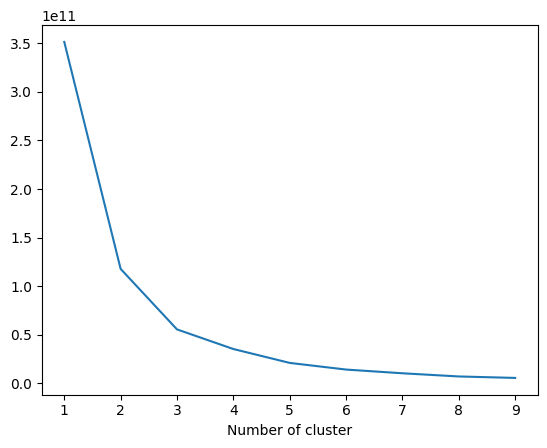

In [ ]:
# Using elbow method to calculate number of clusters for K-Means
sse = {}
tx_recency = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [ ]:
# Apply 4 clustering
kmeans = KMeans(n_clusters = 4, n_init=10)
tx_user['RevenueCluster'] = kmeans.fit_predict(tx_user[['Revenue']])

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,12431,35,3,236,0,6512.41,1
1,12557,15,3,33,0,11990.96,1
2,12779,37,3,149,0,3981.36,1
3,12395,18,3,156,0,3018.63,1
4,12808,36,3,28,0,483.65,1


In [ ]:
# Order the cluster number
tx_user = order_cluster('RevenueCluster', 'Revenue', tx_user, True)

tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,4301.0,1440.397916,2231.636432,3.75,306.45,664.54,1620.930,21429.39
1,31.0,46399.447742,17863.921395,25977.16,31870.25,40991.57,58668.155,91062.38
2,5.0,150138.690000,31640.743166,117379.63,125838.77,144451.76,168472.500,194550.79
3,2.0,270321.900000,15082.021957,259657.30,264989.60,270321.90,275654.200,280986.50


## Overal score based on RFM clustering

In [ ]:
# Calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']

tx_user.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,307.822222,23.131313,402.259798
1,193.109060,33.577181,712.715539
2,85.053644,49.361336,1068.245741
3,21.456203,81.113418,1622.999140
4,11.919847,449.870229,7452.801416
5,4.071429,816.642857,58910.596429
6,7.166667,3334.500000,96274.421667
7,0.333333,2729.333333,228365.186667


Score 8 is the best customer, score 0 is the worst customer.

In [ ]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>3,'Segment'] = 'Mid-Value'
tx_user.loc[tx_user['OverallScore']>7,'Segment'] = 'High-Value'

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,12431,35,3,236,0,6512.41,0,3,Low-Value
1,12557,15,3,33,0,11990.96,0,3,Low-Value
2,12779,37,3,149,0,3981.36,0,3,Low-Value
3,12395,18,3,156,0,3018.63,0,3,Low-Value
4,12808,36,3,28,0,483.65,0,3,Low-Value


# CLV

Lifetime Value = Total Gross Revenue - Total Cost

In [ ]:
df_cleaned['InvoiceDate'].describe()

count                              397924
mean     2011-07-10 23:43:36.912475+00:00
min             2010-12-01 08:26:00+00:00
25%             2011-04-07 11:12:00+00:00
50%             2011-07-31 14:39:00+00:00
75%             2011-10-20 14:33:00+00:00
max             2011-12-09 12:50:00+00:00
Name: InvoiceDate, dtype: object

if the customers are active from 1 dec 2010, then let us consider from April onward (we take the quarter and in April they are not a new consumers)

In [ ]:
df_cleaned['Date'] = pd.to_datetime(df_cleaned['InvoiceDate']).dt.date

In [ ]:
tx_q = df_cleaned[(df_cleaned.Date < date(2011,6,1)) & (df_cleaned.Date >= date(2011,3,1))].reset_index(drop=True)

In [ ]:
#calculate revenue and create a new dataframe for it
tx_q['Revenue'] = tx_q['UnitPrice'] * tx_q['Quantity']
tx_user_q = tx_q.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_q.columns = ['CustomerID','m3_Revenue']

In [ ]:
tx_user_q.head()

,CustomerID,m3_Revenue
0,12347,636.25
1,12348,367.00
2,12352,1265.31
3,12353,89.00
4,12354,1079.40


In [ ]:
#plot LTV histogram
plot_data = [
    go.Histogram(
        x=tx_user_q['m3_Revenue']
    )
]

plot_layout = go.Layout(
        title='Quarter Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

next we merge the quarter data

In [ ]:
tx_merge = pd.merge(tx_user, tx_user_q, on='CustomerID', how='left') #Only people who are in the timeline of tx_user_q

In [ ]:
tx_merge = tx_merge.fillna(0)

In [ ]:
tx_graph = tx_merge.query("m3_Revenue < 53000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m3_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m3_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m3_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Quarter LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
#remove outliers
tx_merge = tx_merge[tx_merge['m3_Revenue']<tx_merge['m3_Revenue'].quantile(0.99)]

In [ ]:
tx_merge

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m3_Revenue
0,12431,35,3,236,0,6512.41,0,3,Low-Value,947.25
1,12557,15,3,33,0,11990.96,0,3,Low-Value,817.50
2,12779,37,3,149,0,3981.36,0,3,Low-Value,1775.83
3,12395,18,3,156,0,3018.63,0,3,Low-Value,658.29
4,12808,36,3,28,0,483.65,0,3,Low-Value,0.00
...,...,...,...,...,...,...,...,...,...,...
4313,12346,325,0,1,0,77183.60,1,1,Low-Value,0.00
4315,15098,181,1,3,0,39916.50,1,2,Low-Value,0.00
4329,14088,9,3,589,1,50491.81,1,5,Mid-Value,0.00
4333,14096,3,3,5111,2,65164.79,1,6,Mid-Value,0.00


In [ ]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3, n_init=10)
tx_merge['LTVCluster'] = kmeans.fit_predict(tx_merge[['m3_Revenue']])

tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m3_Revenue,LTVCluster
0,12431,35,3,236,0,6512.41,0,3,Low-Value,947.25,2
1,12557,15,3,33,0,11990.96,0,3,Low-Value,817.50,2
2,12779,37,3,149,0,3981.36,0,3,Low-Value,1775.83,1
3,12395,18,3,156,0,3018.63,0,3,Low-Value,658.29,2
4,12808,36,3,28,0,483.65,0,3,Low-Value,0.00,0


In [ ]:
#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm3_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m3_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,3437.0,78.003078,129.881540,0.00,0.0000,0.00,140.5400,448.42
1,690.0,816.339783,294.723122,448.65,572.4775,746.51,1011.0825,1547.59
2,169.0,2282.620420,710.619952,1557.76,1716.2700,2008.99,2703.0200,4202.23


###Modelling machine learning

In [ ]:
tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m3_Revenue,LTVCluster
0,12431,35,3,236,0,6512.41,0,3,Low-Value,947.25,1
1,12557,15,3,33,0,11990.96,0,3,Low-Value,817.50,1
2,12395,18,3,156,0,3018.63,0,3,Low-Value,658.29,1
3,12347,1,3,182,0,4310.00,0,3,Low-Value,636.25,1
4,12370,50,3,167,0,3545.69,0,3,Low-Value,938.39,1


In [ ]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster, dtype=int) #There is only one categorical variable segment
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m3_Revenue,LTVCluster,Segment_Low-Value,Segment_Mid-Value
0,12431,35,3,236,0,6512.41,0,3,947.25,1,1,0
1,12557,15,3,33,0,11990.96,0,3,817.50,1,1,0
2,12395,18,3,156,0,3018.63,0,3,658.29,1,1,0
3,12347,1,3,182,0,4310.00,0,3,636.25,1,1,0
4,12370,50,3,167,0,3545.69,0,3,938.39,1,1,0


In [ ]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster           1.000000
m3_Revenue           0.893066
Frequency            0.401429
Segment_Mid-Value    0.394111
FrequencyCluster     0.390054
Revenue              0.369183
OverallScore         0.228188
RecencyCluster       0.152550
RevenueCluster       0.003239
CustomerID          -0.072799
Recency             -0.156622
Segment_Low-Value   -0.394111
Name: LTVCluster, dtype: float64

In [ ]:
tx_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4296 entries, 0 to 4295
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         4296 non-null   Int64  
 1   Recency            4296 non-null   int64  
 2   RecencyCluster     4296 non-null   int64  
 3   Frequency          4296 non-null   int64  
 4   FrequencyCluster   4296 non-null   int64  
 5   Revenue            4296 non-null   float64
 6   RevenueCluster     4296 non-null   int64  
 7   OverallScore       4296 non-null   int64  
 8   m3_Revenue         4296 non-null   float64
 9   LTVCluster         4296 non-null   int64  
 10  Segment_Low-Value  4296 non-null   int64  
 11  Segment_Mid-Value  4296 non-null   int64  
dtypes: Int64(1), float64(2), int64(9)
memory usage: 407.1 KB


In [ ]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m3_Revenue'],axis=1)
y = tx_class['LTVCluster']

# mengubah Label Menjadi 0-Indexed:
#y = y - 1
#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3007 entries, 1777 to 860
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         3007 non-null   Int64  
 1   Recency            3007 non-null   int64  
 2   RecencyCluster     3007 non-null   int64  
 3   Frequency          3007 non-null   int64  
 4   FrequencyCluster   3007 non-null   int64  
 5   Revenue            3007 non-null   float64
 6   RevenueCluster     3007 non-null   int64  
 7   OverallScore       3007 non-null   int64  
 8   Segment_Low-Value  3007 non-null   int64  
 9   Segment_Mid-Value  3007 non-null   int64  
dtypes: Int64(1), float64(1), int64(8)
memory usage: 261.4 KB


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1289 entries, 309 to 2974
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1289 non-null   Int64  
 1   Recency             1289 non-null   int64  
 2   RecencyCluster      1289 non-null   int64  
 3   Frequency           1289 non-null   int64  
 4   FrequencyCluster    1289 non-null   int64  
 5   Revenue             1289 non-null   float64
 6   RevenueCluster      1289 non-null   int64  
 7   OverallScore        1289 non-null   int64  
 8   Segment_High-Value  1289 non-null   int64  
 9   Segment_Low-Value   1289 non-null   int64  
 10  Segment_Mid-Value   1289 non-null   int64  
dtypes: Int64(1), float64(1), int64(9)
memory usage: 122.1 KB


In [ ]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)

Accuracy of XGB classifier on training set: 0.94
Accuracy of XGB classifier on test set: 0.85


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      1018
           1       0.59      0.48      0.53       221
           2       0.54      0.58      0.56        50

    accuracy                           0.85      1289
   macro avg       0.68      0.67      0.67      1289
weighted avg       0.84      0.85      0.84      1289



let's try another models

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
models = {
    'K-Nearest Neighbors' : KNeighborsClassifier(),
    'Logistic Regression' : LogisticRegression(max_iter=1000),
    'Random Forest' : RandomForestClassifier(),
    'Gradient Boosting' : GradientBoostingClassifier()
}

for name, model in models.items():
    print(f'{name} training started')
    model.fit(X_train, y_train)
    print(f'{name} trained')
    print("*"*40)
print("FINISHED")

K-Nearest Neighbors training started
K-Nearest Neighbors trained
****************************************
Logistic Regression training started
Logistic Regression trained
****************************************
Random Forest training started
Random Forest trained
****************************************
Gradient Boosting training started
Gradient Boosting trained
****************************************
FINISHED


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification

In [ ]:
for name in models:
    acc_score= round(accuracy_score(y_train, models.get(name).predict(X_train)), 3)
    print(f'{name} accuracy train score :  {acc_score}')

K-Nearest Neighbors accuracy train score :  0.883
Logistic Regression accuracy train score :  0.838
Random Forest accuracy train score :  1.0
Gradient Boosting accuracy train score :  0.922


In [ ]:
for name in models:
    acc_score= round(accuracy_score(y_test, models.get(name).predict(X_test)), 3)
    print(f'{name} accuracy score :  {acc_score}')

K-Nearest Neighbors accuracy score :  0.809
Logistic Regression accuracy score :  0.823
Random Forest accuracy score :  0.84
Gradient Boosting accuracy score :  0.847


In [ ]:
for name in models:
    print(f'{name} classification report')
    print("-------------------------------")
    print(classification_report(y_test, models.get(name).predict(X_test)))
    print("******************************")
    print(" ")

K-Nearest Neighbors classification report
-------------------------------
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1018
           1       0.46      0.33      0.38       221
           2       0.60      0.52      0.56        50

    accuracy                           0.81      1289
   macro avg       0.64      0.59      0.61      1289
weighted avg       0.79      0.81      0.80      1289

******************************
 
Logistic Regression classification report
-------------------------------
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      1018
           1       0.54      0.26      0.35       221
           2       0.58      0.28      0.38        50

    accuracy                           0.82      1289
   macro avg       0.66      0.50      0.55      1289
weighted avg       0.79      0.82      0.79      1289

******************************
 
Random Forest classifica

# Python Code Writing

Ini nanti dijadiin satu code untuk RFM calculation.

In [ ]:
# Install necessary libraries
!pip install google-cloud-bigquery
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

# Authenticate and setup Google Cloud SDK
from google.colab import auth

from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import pickle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


In [ ]:
# Load data from BigQuery
query = """
SELECT *
FROM `finalproject-g2df12.retail.transaction_cleaned`
"""

# Load data into a DataFrame
rfm_df = client.query(query).to_dataframe()

In [ ]:
# Perform RFM segmentation
# Calculate total purchase each transaction
rfm_df['TotalPurchase'] = rfm_df['UnitPrice'] * rfm_df['Quantity']

# Define the current date
current_date = rfm_df['InvoiceDate'].max() + pd.DateOffset(1)

# Calculate the difference between the current date and the invoice date
rfm = rfm_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (current_date - date.max()).days,
    'InvoiceNo': lambda num: len(num),
    'Quantity': lambda quant: quant.sum(),
    'TotalPurchase': lambda price: price.sum()
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Density', 'Monetary']
rfm = rfm.reset_index()

In [ ]:
# Define RFM score calculation
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['F_Score'] = pd.qcut(rfm['Frequency'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5], duplicates='drop')

# Calculate RFM score
rfm['RFM_Score'] = (rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)).astype(int)

In [ ]:
# Import the necessary libraries
import re

# Define the mapping function
def map_segment(rfm_score):
    seg_map = {
        r'111|112|121|131|141|151': 'Lost customers',
        r'332|322|233|232|223|222|132|123|122|212|211': 'Hibernating customers',
        r'155|154|144|214|215|115|114|113': 'Cannot Lose Them',
        r'255|254|245|244|253|252|243|242|235|234|225|224|153|152|145|143|142|135|134|133|125|124': 'At Risk',
        r'331|321|312|221|213|231|241|251': 'About To Sleep',
        r'535|534|443|434|343|334|325|324': 'Need Attention',
        r'525|524|523|522|521|515|514|513|425|424|413|414|415|315|314|313': 'Promising',
        r'512|511|422|421|412|411|311': 'New Customers',
        r'553|551|552|541|542|533|532|531|452|451|442|441|431|453|433|432|423|353|352|351|342|341|333|323': 'Potential Loyalist',
        r'543|444|435|355|354|345|344|335': 'Loyal',
        r'555|554|544|545|454|455|445': 'Champions'
    }
    for pattern, segment in seg_map.items():
        if re.match(pattern, str(rfm_score)):
            return segment
    return 'Unknown'

# Apply the mapping function
rfm['segment'] = rfm['RFM_Score'].apply(map_segment)

# Display the DataFrame
rfm.head()

,CustomerID,Recency,Frequency,Density,Monetary,R_Score,F_Score,M_Score,RFM_Score,segment
0,12346,326,1,74215.0,77183.60,1,1,5,115,Cannot Lose Them
1,12347,2,182,2458.0,4310.00,5,5,5,555,Champions
2,12348,75,31,2341.0,1797.24,2,3,4,234,At Risk
3,12349,19,73,631.0,1757.55,4,4,4,444,Loyal
4,12350,310,17,197.0,334.40,1,2,2,122,Hibernating customers


In [ ]:
# # Calculate quantiles for segmentation
# quantiles = rfm['RFM_Score'].quantile([0.33, 0.66]).values

# # Define a function to assign segments based on quantiles
# def segment_rfm(score):
#     if score <= quantiles[0]:
#         return 'Low'
#     elif score <= quantiles[1]:
#         return 'Mid'
#     else:
#         return 'High'

# # Apply the segmentation function
# rfm['Segment'] = rfm['RFM_Score'].apply(segment_rfm)

In [ ]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4340 entries, 0 to 4339
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CustomerID  4340 non-null   Int64   
 1   Recency     4340 non-null   int64   
 2   Frequency   4340 non-null   int64   
 3   Density     4340 non-null   float64 
 4   Monetary    4340 non-null   float64 
 5   R_Score     4340 non-null   category
 6   F_Score     4340 non-null   category
 7   M_Score     4340 non-null   category
 8   RFM_Score   4340 non-null   int64   
 9   segment     4340 non-null   object  
dtypes: Int64(1), category(3), float64(2), int64(3), object(1)
memory usage: 255.0+ KB


##Modelling

In [ ]:
# Feature Engineering
# Convert segment into numerical values using one-hot encoding
column_transformer = ColumnTransformer([
    ('segment', OneHotEncoder(), ['segment'])
], remainder='passthrough')

In [ ]:
# Define features and target variable
X = rfm[['R_Score', 'F_Score', 'M_Score', 'segment']]
y = rfm['Monetary']  # Assuming 'Monetary' as the CLV here

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Standardize the features
scaler = StandardScaler(with_mean=False)

In [ ]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

In [ ]:
# Initialize a dictionary to store model performance
model_performance = {}


In [ ]:
# Train and evaluate each model
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', column_transformer),
        ('scaler', scaler),
        ('regressor', model)
    ])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_mean = np.mean(cv_scores)

    # Store the performance
    model_performance[model_name] = {'MSE': mse, 'R2': r2, 'MAPE': mape, 'CV_MSE': -cv_mean}

    # Save the model using pickle
    with open(f'{model_name.replace(" ", "_").lower()}_model.pkl', 'wb') as file:
        pickle.dump(pipeline, file)


In [ ]:
# Display model performance
for model_name, metrics in model_performance.items():
    print(f"{model_name} - MSE: {metrics['MSE']}, R2: {metrics['R2']}, MAPE: {metrics['MAPE']}, CV_MSE: {metrics['CV_MSE']}")


Linear Regression - MSE: 4200145010.756823, R2: 0.005867555933348756, MAPE: 2.475465552159814, CV_MSE: 91320748.07745409
Random Forest - MSE: 4180766518.0613384, R2: 0.010454251929880254, MAPE: 0.47795777991528715, CV_MSE: 89477937.56398152
Decision Tree - MSE: 4180734656.36493, R2: 0.010461793275724607, MAPE: 0.4759023594223191, CV_MSE: 89034155.0995295
Support Vector Regressor - MSE: 4231553945.041147, R2: -0.001566625630772478, MAPE: 0.8093617386872379, CV_MSE: 100199499.70098177


In [ ]:
# Loading a model and making predictions on new data
# Example with Random Forest model
loaded_model_filename = 'random_forest_model.pkl'

with open(loaded_model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

# Assuming new_data is the new dataset for prediction
# new_data = ...

# Predicting CLV for new data
# new_data_predictions = loaded_model.predict(new_data)

# Display predictions
# print(new_data_predictions)

# Some Visualization

In [ ]:
!pip install squarify
import squarify

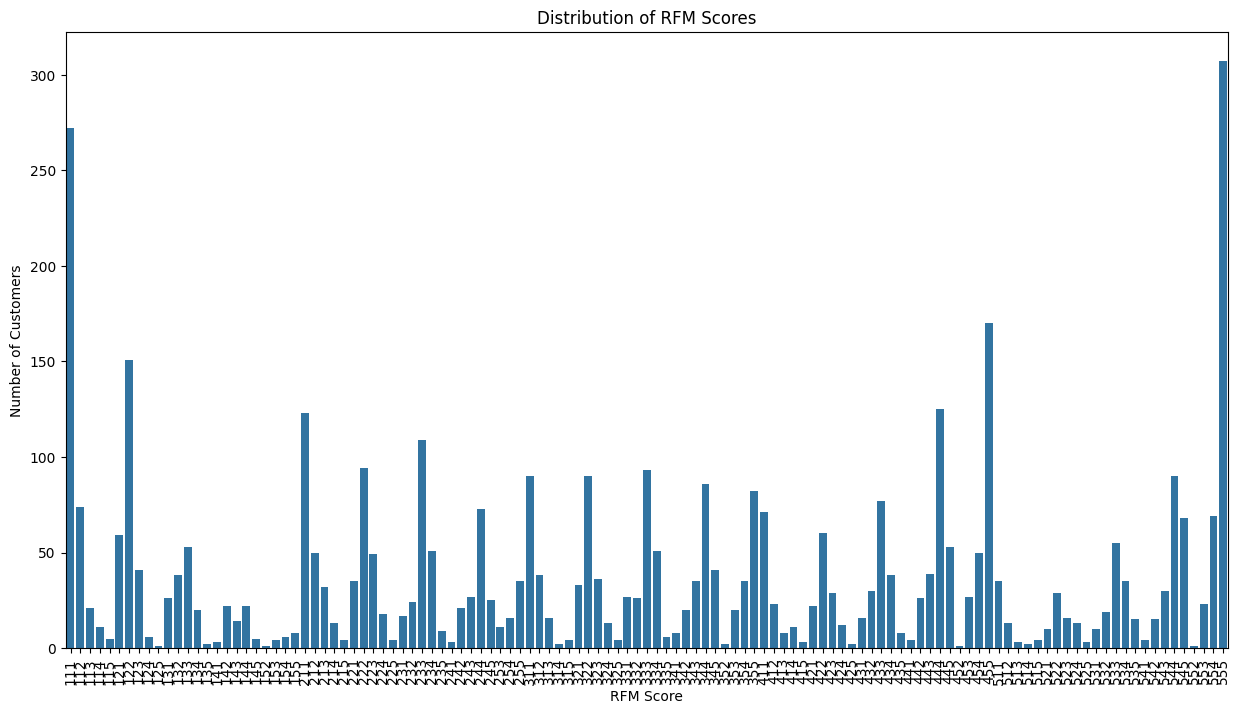

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

rfm_score_counts = rfm['RFM_Score'].value_counts().reset_index()
rfm_score_counts.columns = ['RFM_Score', 'Count']

# Plot the distribution of RFM scores
plt.figure(figsize=(15, 8))
sns.barplot(x='RFM_Score', y='Count', data=rfm_score_counts)
plt.title('Distribution of RFM Scores')
plt.xlabel('RFM Score')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)  # Rotate x-axis labels if needed
plt.show()

This plot shows the number of customers in each RFM score category, providing a clear picture of the distribution.

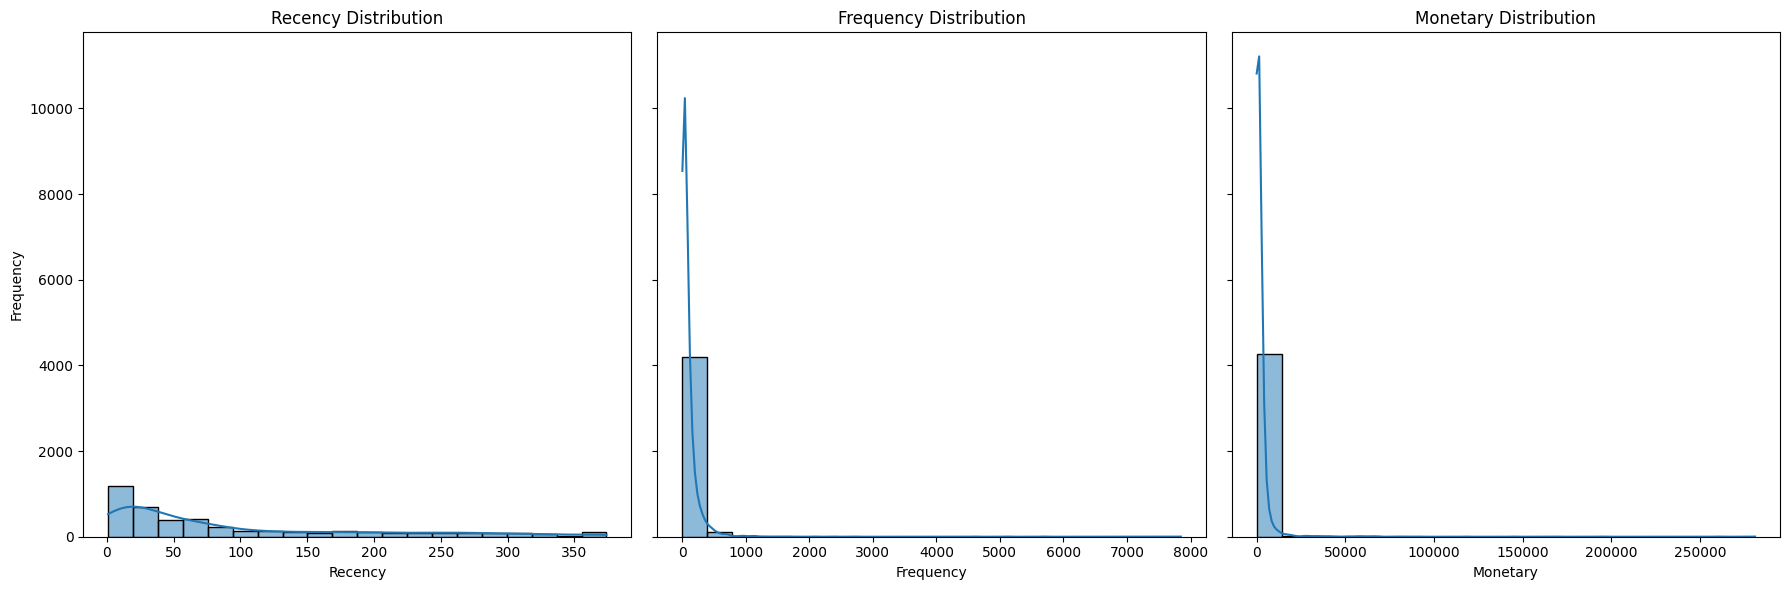

In [ ]:
# Plot the distribution of Recency, Frequency, and Monetary scores
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

sns.histplot(rfm['Recency'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')

sns.histplot(rfm['Frequency'], bins=20, kde=True, ax=axes[1])
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Frequency')

sns.histplot(rfm['Monetary'], bins=20, kde=True, ax=axes[2])
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Monetary')

plt.tight_layout()
plt.show()

These plots help to understand the distribution of each individual component of the RFM score.

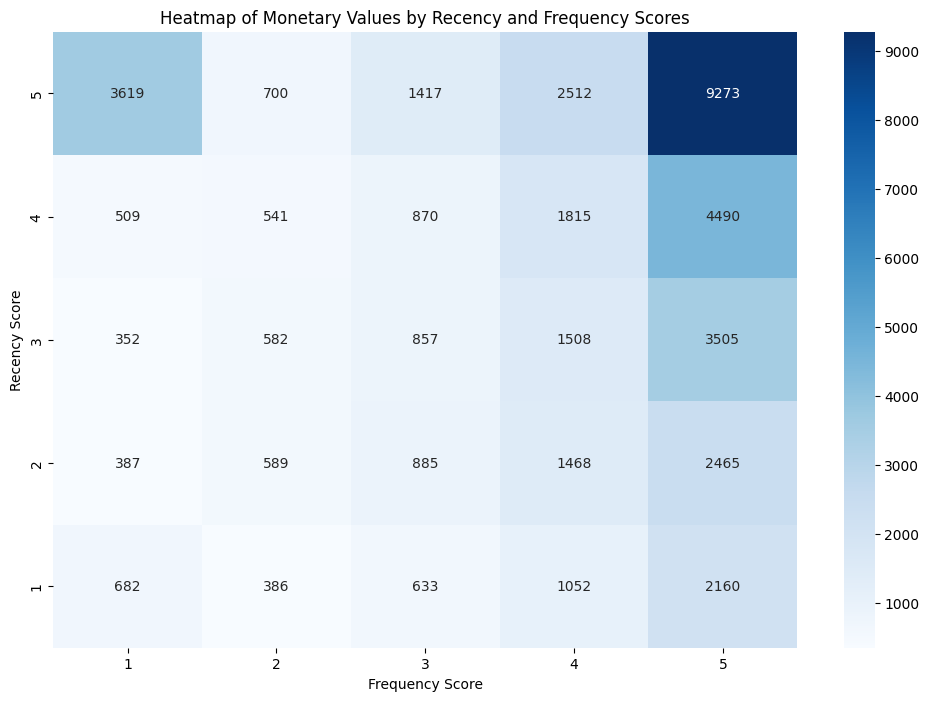

In [ ]:
# Create a pivot table for Recency and Frequency
rfm_pivot = rfm.pivot_table(index='R_Score', columns='F_Score', values='Monetary', aggfunc='mean').fillna(0)

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(rfm_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Heatmap of Monetary Values by Recency and Frequency Scores')
plt.xlabel('Frequency Score')
plt.ylabel('Recency Score')
plt.show()

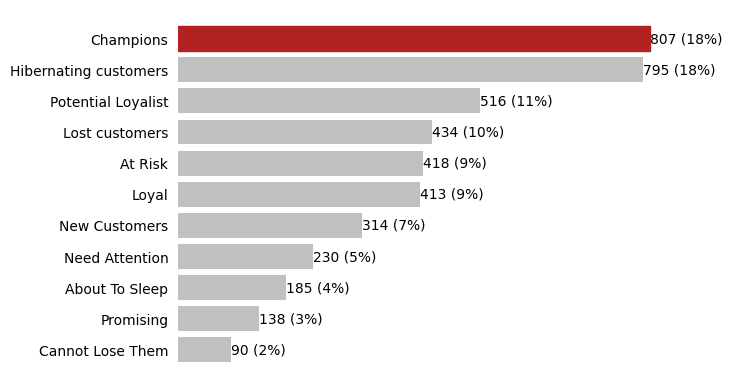

In [ ]:
# count the number of customers in each segment
segments_counts = rfm['segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Champions', 'Loyal customers']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

In [ ]:
# Calculate average values for each RFM segment, and return a size of each segment
rfm_vis = rfm.groupby('segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'],
}).round(1)
# Print the aggregated dataset
rfm_vis

Recency Frequency Monetary      
                         mean      mean     mean count
segment                                               
About To Sleep           87.7      21.9    287.9   185
At Risk                 157.1      81.6   1522.4   418
Cannot Lose Them        219.8      50.9   3316.3    90
Champions                11.6     451.4   9187.5   807
Hibernating customers   149.7      23.5    404.4   795
Lost customers          278.7      11.7    179.3   434
Loyal                    38.4     119.5   2392.5   413
Need Attention           33.4      57.3   1496.7   230
New Customers            29.4      11.2    211.0   314
Potential Loyalist       29.2      62.1    586.2   516
Promising                18.8      16.4   2449.0   138

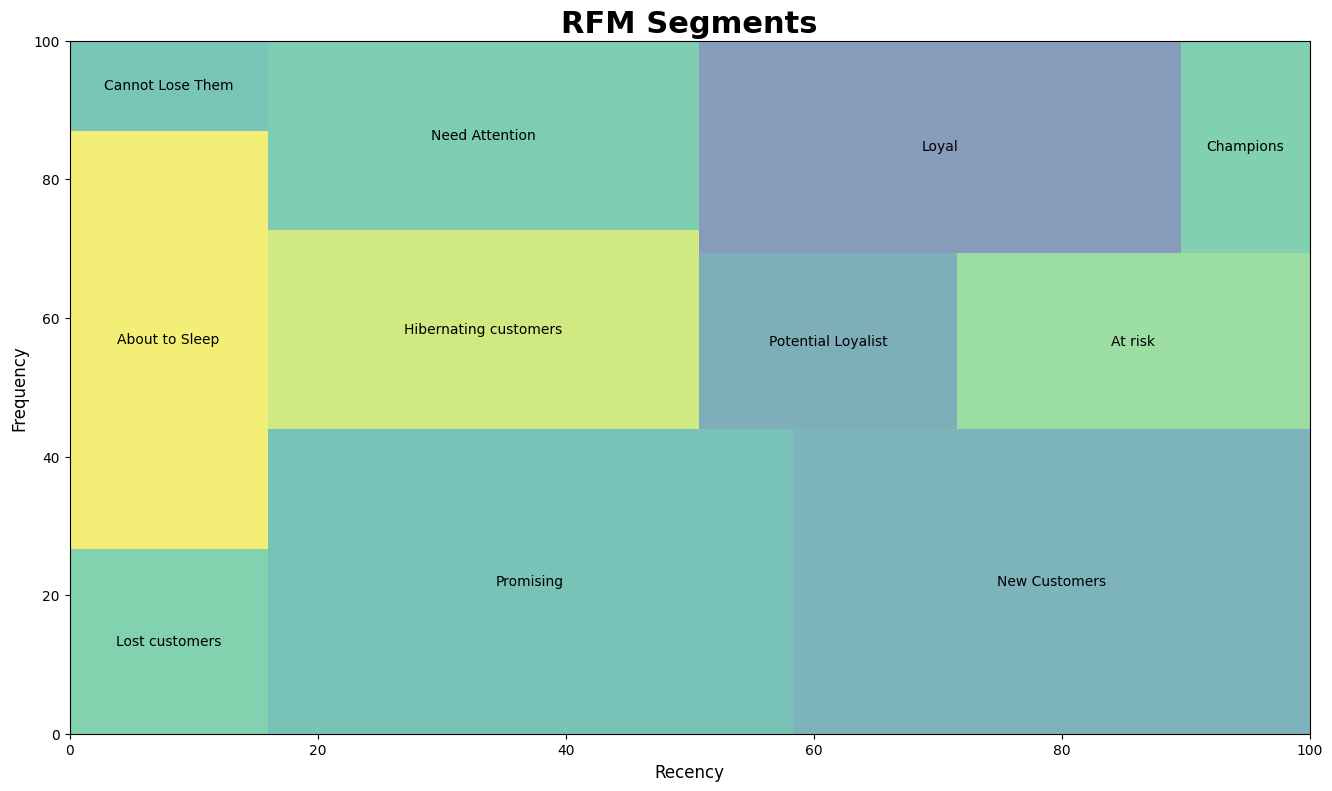

In [ ]:
# Assuming rfm_vis has been created previously and has the correct values

# Rename columns for clarity
rfm_vis.columns = ['Recencymean', 'Frequencymean', 'Monetarymean', 'Count']

# Set up the plot
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)

# Correct labels with missing comma
squarify.plot(sizes=rfm_vis['Count'],
              label=['Lost customers',
                     'About to Sleep',
                     'Cannot Lose Them',
                     'Promising',
                     'New Customers',
                     'Hibernating customers',
                     'Need Attention',
                     'Potential Loyalist',
                     'At risk',
                     'Loyal',
                     'Champions'],
              alpha=.6)

# Add title and axis labels
plt.title("RFM Segments", fontsize=22, fontweight="bold")
ax.set_xlabel('Recency', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.axis('on')

# Show the plot
plt.show()

This plot shows the interaction between Recency and Frequency scores, with the average Monetary value providing additional insight.

Ini nanti dijadiin satu code untuk CLV prediction ⏬

# BG/NBD model with pymc_marketing

In [ ]:
rfm_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear
0,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6.0,2010-12-01 10:03:00+00:00,8.50,12431,Australia,2010,12,1,2,48
1,536389,21622,VINTAGE UNION JACK CUSHION COVER,8.0,2010-12-01 10:03:00+00:00,4.95,12431,Australia,2010,12,1,2,48
2,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12.0,2010-12-01 10:03:00+00:00,1.25,12431,Australia,2010,12,1,2,48
3,536389,35004,SET OF 3 COLOURED FLYING DUCKS,6.0,2010-12-01 10:03:00+00:00,5.45,12431,Australia,2010,12,1,2,48
4,536389,35004,SET OF 3 GOLD FLYING DUCKS,4.0,2010-12-01 10:03:00+00:00,6.35,12431,Australia,2010,12,1,2,48


In [ ]:
# Summarizing the dataset's content to understand its scope
rfm_df['TotalSales'] = rfm_df['Quantity'].multiply(rfm_df['UnitPrice'])
maxdate = rfm_df['InvoiceDate'].dt.date.max()
mindate = rfm_df['InvoiceDate'].dt.date.min()
unique_cust = rfm_df['CustomerID'].nunique()
tot_quantity = rfm_df['Quantity'].sum()
tot_sales = rfm_df['TotalSales'].sum()

print(f"The Time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total Quantity Sold: {tot_quantity}")
print(f"Total Sales for the period: {tot_sales}")

The Time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4340
Total Quantity Sold: 5651448.0
Total Sales for the period: 10840829.554999996


In [ ]:
rfm_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year,Month,Day,DayOfWeek,WeekOfYear,TotalSales
0,536389,22941,CHRISTMAS LIGHTS 10 REINDEER,6.0,2010-12-01 10:03:00+00:00,8.50,12431,Australia,2010,12,1,2,48,51.0
1,536389,21622,VINTAGE UNION JACK CUSHION COVER,8.0,2010-12-01 10:03:00+00:00,4.95,12431,Australia,2010,12,1,2,48,39.6
2,536389,21791,VINTAGE HEADS AND TAILS CARD GAME,12.0,2010-12-01 10:03:00+00:00,1.25,12431,Australia,2010,12,1,2,48,15.0
3,536389,35004,SET OF 3 COLOURED FLYING DUCKS,6.0,2010-12-01 10:03:00+00:00,5.45,12431,Australia,2010,12,1,2,48,32.7
4,536389,35004,SET OF 3 GOLD FLYING DUCKS,4.0,2010-12-01 10:03:00+00:00,6.35,12431,Australia,2010,12,1,2,48,25.4


In [ ]:
!pip install pymc-marketing
from pymc_marketing import clv
import pymc as pm
import arviz as az
from arviz.labels import MapLabeller

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.6/484.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.4 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.18.6
    Uninstalling pytensor-2.18.6:
      Successfully uninstalled pytensor-2.18.6
  Attempting uninstall: pymc
    Found existing installation: pymc 5.10.4
    Uninstalling pymc-5.10.4:
      Successfully uninstalled pymc-5.10.4


In [ ]:
# Here, we prepare a summary from transaction data, transforming individual transaction data into data at the customer level.

data_summary_rfm = clv.utils.clv_summary(rfm_df, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
data_summary_rfm.head()

/usr/local/lib/python3.10/dist-packages/pymc_marketing/clv/utils.py:286: UserWarning:

clv_summary was renamed to rfm_summary

/usr/local/lib/python3.10/dist-packages/pymc_marketing/clv/utils.py:357: UserWarning:

Converting to Period representation will drop timezone information.

/usr/local/lib/python3.10/dist-packages/pymc_marketing/clv/utils.py:246: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
12346,12346,0.0,0.0,325.0,0.000000
12347,12347,6.0,365.0,367.0,599.701667
12348,12348,3.0,283.0,358.0,301.480000
12349,12349,0.0,0.0,18.0,0.000000
12350,12350,0.0,0.0,310.0,0.000000


In [ ]:
data_summary_rfm = data_summary_rfm[data_summary_rfm['monetary_value'] > 0]

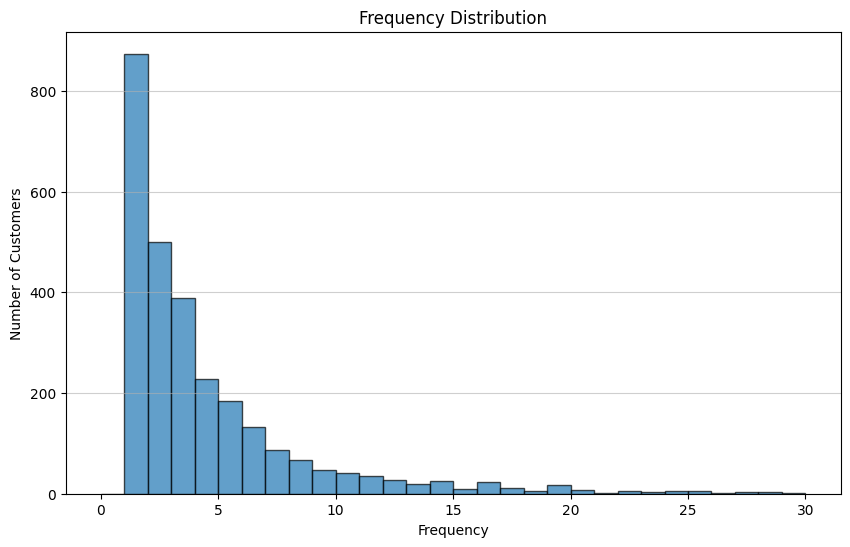

Percentage of customers who purchased only once: 31.31%


In [ ]:
# Plotting the frequency distribution of customers
plt.figure(figsize=(10, 6))
plt.hist(data_summary_rfm['frequency'], bins=30, range=[0, 30], edgecolor='k', alpha=0.7)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

one_time = round(sum(data_summary_rfm['frequency'] == 1) / float(len(data_summary_rfm)) * 100, 2)
print(f"Percentage of customers who purchased only once: {one_time}%")

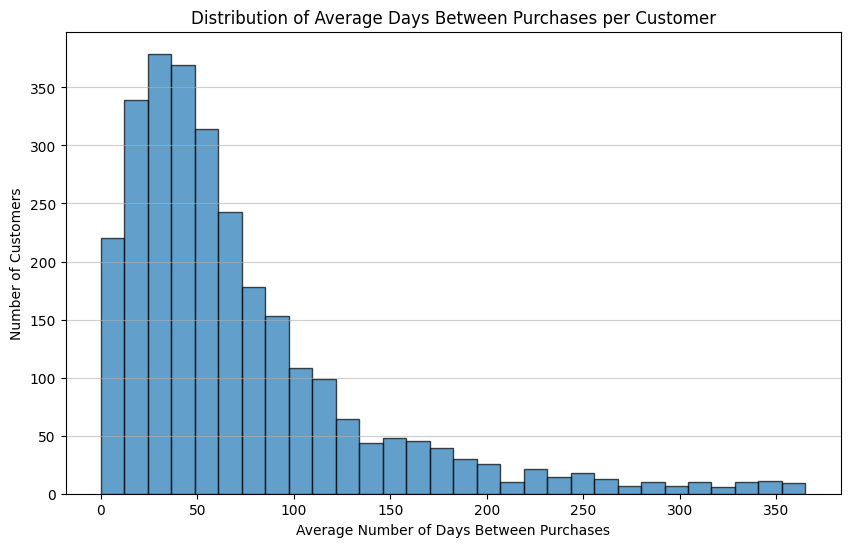

In [ ]:
# Calculating Days Between Purchases

# Select distinct CustomerID and InvoiceDate
rfm_df['InvoiceDate'] = pd.to_datetime(rfm_df['InvoiceDate'])
unique_purchases = rfm_df[['CustomerID', 'InvoiceDate']].drop_duplicates()

# Sorting values to ensure the calculation of the difference correctly
unique_purchases = unique_purchases.sort_values(['CustomerID', 'InvoiceDate'])

# Calculating the difference in days between current and next purchase
unique_purchases['NextInvoiceDate'] = unique_purchases.groupby('CustomerID')['InvoiceDate'].shift(-1)
unique_purchases['DaysBetween'] = (unique_purchases['NextInvoiceDate'] - unique_purchases['InvoiceDate']).dt.days

# Calculating Average Days
customer_avg_days = unique_purchases.groupby('CustomerID')['DaysBetween'].mean().dropna()

# Plotting the Histogram
plt.figure(figsize=(10, 6))
plt.hist(customer_avg_days, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Average Days Between Purchases per Customer')
plt.xlabel('Average Number of Days Between Purchases')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

In [ ]:
data_summary_rfm

,customer_id,frequency,recency,T,monetary_value
customer_id,,,,,
12347,12347,6.0,365.0,367.0,599.701667
12348,12348,3.0,283.0,358.0,301.480000
12352,12352,6.0,260.0,296.0,368.256667
12356,12356,2.0,303.0,325.0,269.905000
12358,12358,1.0,149.0,150.0,683.200000
...,...,...,...,...,...
18273,18273,2.0,255.0,257.0,76.500000
18282,18282,1.0,119.0,126.0,77.840000
18283,18283,13.0,334.0,337.0,152.802308


In [ ]:
# Initializing the BG/NBD model.
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfFlat()
         b ~ HalfFlat()
     alpha ~ HalfFlat()
         r ~ HalfFlat()
likelihood ~ Potential(f(r, alpha, b, a))

In [ ]:
# While the default priors work well for large datasets, they can be too broad or non-informative for smaller datasets.
# Therefore, we're refining our model by specifying more informative priors for the model's parameters.
# This step helps in guiding the model towards more realistic areas of the parameter space.

model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma': 100}},
}

In [ ]:
# Rebuilding the model with updated prior configurations.
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
         a ~ HalfNormal(0, 100)
         b ~ HalfNormal(0, 100)
     alpha ~ HalfNormal(0, 100)
         r ~ HalfNormal(0, 100)
likelihood ~ Potential(f(r, alpha, b, a))

In [ ]:
bgm.fit()

Output()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



Inference data with groups:
	> posterior
	> sample_stats
	> fit_data

In [ ]:
bgm.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.013,0.005,0.005,0.023,0.000,0.000,739.0,642.0,1.0
b,0.266,0.117,0.061,0.457,0.004,0.003,717.0,643.0,1.0
alpha,100.012,3.834,92.311,106.527,0.121,0.086,1002.0,895.0,1.0
r,1.817,0.064,1.696,1.931,0.002,0.001,1036.0,1151.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning:

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.



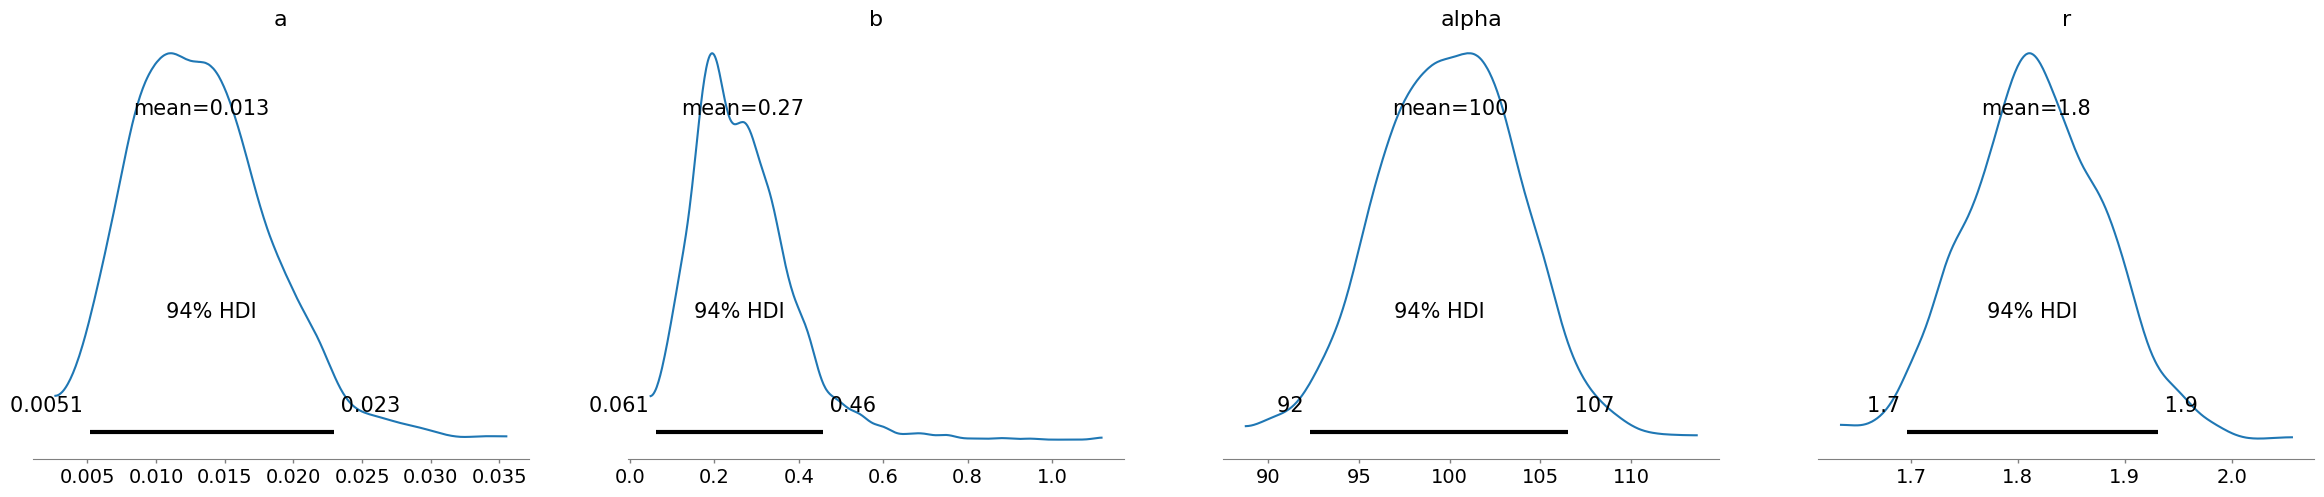

In [ ]:
# Visualizing the posterior distributions of the parameters.
# These distributions show the range of probable values for each parameter, considering the observed data.

az.plot_posterior(bgm.fit_result);

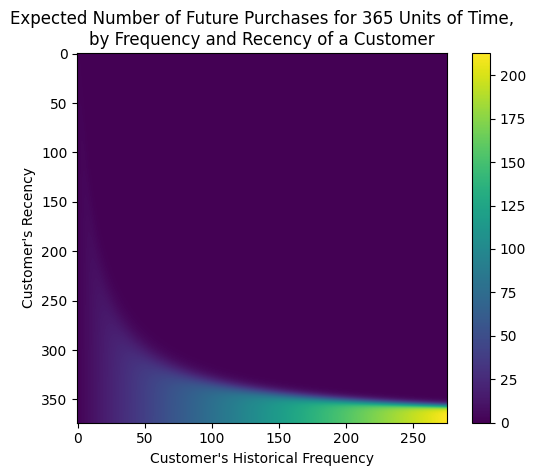

In [ ]:
# Analyzing customer behavior using a Frequency/Recency matrix, which visualizes customer archetypes.
# This matrix helps in identifying patterns like potentially "at-risk" customers who might churn.

clv.plot_frequency_recency_matrix(bgm, t=365);

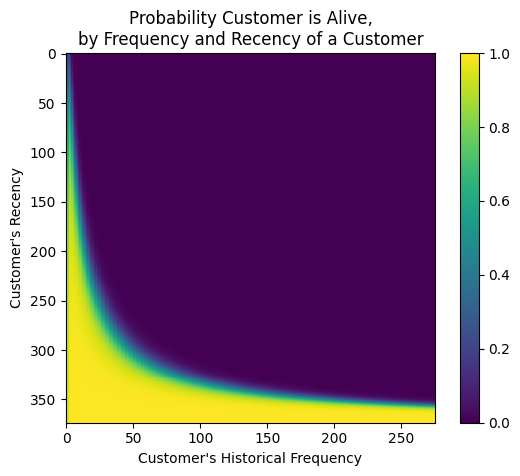

In [ ]:
# The Probability Alive Matrix visualizes the likelihood of customers still being active. This view is essential for identifying potentially lost customers and understanding overall customer retention.

clv.plot_probability_alive_matrix(bgm);

In [ ]:
# Predicting future purchases within the next 365 days using the fitted model.

num_purchases = bgm.expected_num_purchases(
    customer_id=data_summary_rfm["customer_id"],
    t=365,
    frequency=data_summary_rfm["frequency"],
    recency=data_summary_rfm["recency"],
    T=data_summary_rfm["T"]
)

In [ ]:
# We add expected purchases to our data summary and display the customers with the highest expected purchases.

sdata = data_summary_rfm.copy()
sdata["expected_purchases"] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

,customer_id,frequency,recency,T,monetary_value,expected_purchases
customer_id,,,,,,
17841,17841,111.0,372.0,373.0,364.452162,86.680535
12748,12748,113.0,373.0,373.0,298.371947,88.220364
14911,14911,131.0,372.0,373.0,1098.445649,102.050160
99999,99999,275.0,373.0,373.0,6920.320327,212.718662


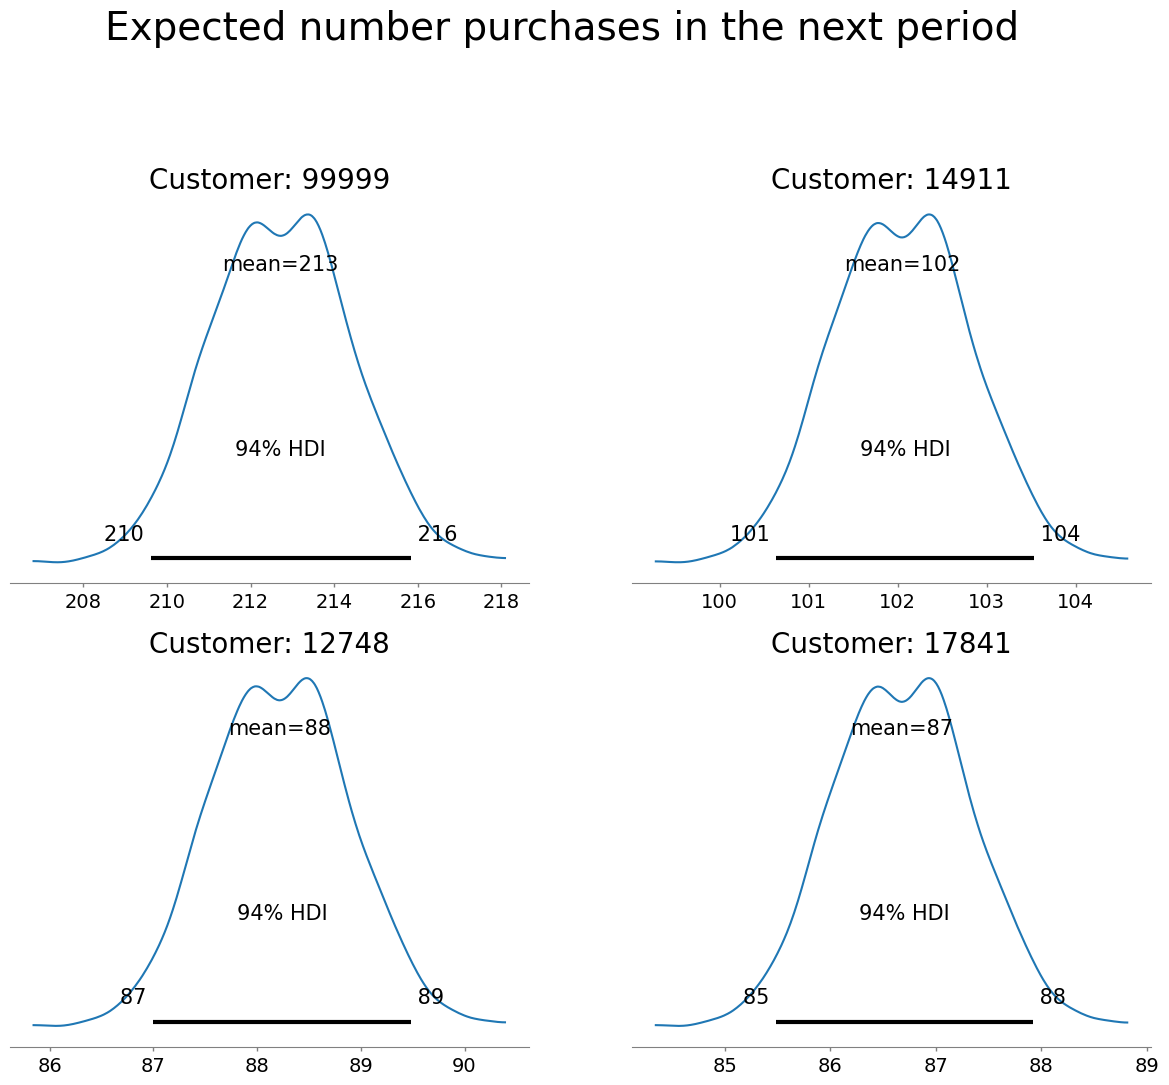

In [ ]:
# Here, we're visualizing the uncertainty in our predictions for the number of purchases.
# This step illustrates the range of likely outcomes, highlighting the probabilistic nature of our predictions.

ids = sdata.sort_values(by="expected_purchases", ascending=False).head(4)['customer_id'].tolist()
ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2));
for axi, id in zip(ax.ravel(), ids):
    axi.set_title(f"Customer: {id}", size=20)
plt.suptitle("Expected number purchases in the next period", fontsize=28, y=1.05);

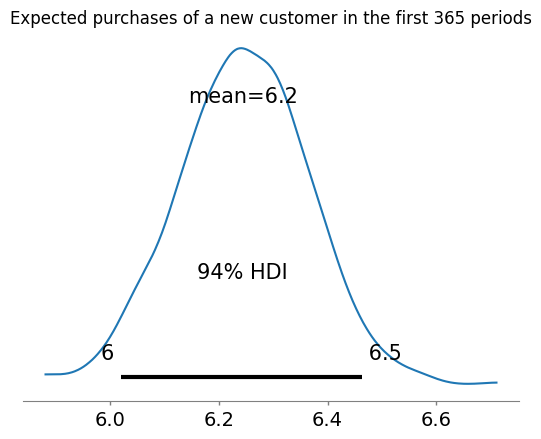

In [ ]:
# Estimating the purchasing behavior of a completely new customer.
# This prediction is useful for understanding what purchasing behavior might be expected from prospective customers.

az.plot_posterior(
    bgm.expected_num_purchases_new_customer(t=365)
);
plt.title("Expected purchases of a new customer in the first 365 periods");

# BG/NBD model with lifetimes

In [ ]:
!pip install lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
import pickle

## BG/NBD (regresion)

In [ ]:
# Set up the BigQuery client
project_id = 'finalproject-g2df12'
client = bigquery.Client(project=project_id)

# Load data from BigQuery
query = """
SELECT *
FROM `finalproject-g2df12.retail.transaction_cleaned`
"""

# Load data into a DataFrame
df_cleaned = client.query(query).to_dataframe()

# Convert InvoiceDate to datetime
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate']).dt.tz_localize(None)


In [ ]:
# Prepare data for BG/NBD model
summary = summary_data_from_transaction_data(df_cleaned, 'CustomerID', 'InvoiceDate', observation_period_end='2011-12-09')

# Fit the model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Predict the number of future transactions
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(30, summary['frequency'], summary['recency'], summary['T'])

# Calculate additional features
summary['avg_order_value'] = df_cleaned.groupby('CustomerID')['Revenue'].sum() / df_cleaned.groupby('CustomerID')['InvoiceNo'].nunique()
summary['tenure'] = summary['T']

In [ ]:
summary

,frequency,recency,T,predicted_purchases,avg_order_value,tenure
CustomerID,,,,,,
12346,0.0,0.0,325.0,0.061154,77183.600000,325.0
12347,6.0,365.0,367.0,0.471416,615.714286,367.0
12348,3.0,283.0,358.0,0.268704,449.310000,358.0
12349,0.0,0.0,18.0,0.286672,1757.550000,18.0
12350,0.0,0.0,310.0,0.063599,334.400000,310.0
...,...,...,...,...,...,...
18281,0.0,0.0,180.0,0.097310,80.820000,180.0
18282,1.0,119.0,126.0,0.281417,89.025000,126.0
18283,13.0,334.0,337.0,1.028513,130.930000,337.0


## Classification

In [ ]:
# Create segments based on predicted_purchases
summary['CLV_segment'] = pd.qcut(summary['predicted_purchases'], q=3, labels=['Low', 'Mid', 'High'])

# Map CLV segments to numerical labels
segment_mapping = {'Low': 0, 'Mid': 1, 'High': 2}
summary['CLV_segment_encoded'] = summary['CLV_segment'].map(segment_mapping)


In [ ]:
summary.head()

,frequency,recency,T,predicted_purchases,avg_order_value,tenure,CLV_segment,CLV_segment_encoded
CustomerID,,,,,,,,
12346,0.0,0.0,325.0,0.061154,77183.600000,325.0,Low,0
12347,6.0,365.0,367.0,0.471416,615.714286,367.0,High,2
12348,3.0,283.0,358.0,0.268704,449.310000,358.0,Mid,1
12349,0.0,0.0,18.0,0.286672,1757.550000,18.0,Mid,1
12350,0.0,0.0,310.0,0.063599,334.400000,310.0,Low,0


In [ ]:
# Select features and labels
features = ['predicted_purchases', 'frequency', 'recency', 'avg_order_value', 'tenure']
X = summary[features]
y = summary['CLV_segment_encoded']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3038, 5)
(1302, 5)
(3038,)
(1302,)


In [ ]:
# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Models
models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'LogisticRegression': LogisticRegression(),
    'XGBoost': XGBClassifier()
}

In [ ]:
for name, model in models.items():
    print(f'{name} training started')
    model.fit(X_train, y_train)
    print(f'{name} trained')
    print("*"*40)
print("FINISHED")

RandomForest training started
RandomForest trained
****************************************
GradientBoosting training started
GradientBoosting trained
****************************************
LogisticRegression training started
LogisticRegression trained
****************************************
XGBoost training started
XGBoost trained
****************************************
FINISHED


In [ ]:
for name in models:
    acc_score= round(accuracy_score(y_train, models.get(name).predict(X_train)), 3)
    print(f'{name} accuracy train score :  {acc_score}')

RandomForest accuracy train score :  1.0
GradientBoosting accuracy train score :  1.0
LogisticRegression accuracy train score :  0.976
XGBoost accuracy train score :  1.0


In [ ]:
for name in models:
    acc_score_test= round(accuracy_score(y_test, models.get(name).predict(X_test)), 3)
    print(f'{name} accuracy test score :  {acc_score_test}')

RandomForest accuracy test score :  0.999
GradientBoosting accuracy test score :  0.999
LogisticRegression accuracy test score :  0.987
XGBoost accuracy test score :  0.999


In [ ]:
# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'{name} Classification Report:')
    print(classification_report(y_test, y_pred))

    # Save model
    with open(f'{name}_model.pkl', 'wb') as file:
      pickle.dump(model, file)

    # Save scaler
    with open('scaler.pkl', 'wb') as file:
      pickle.dump(scaler, file)

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       441
           1       1.00      1.00      1.00       438
           2       1.00      1.00      1.00       423

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302

GradientBoosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       441
           1       1.00      1.00      1.00       438
           2       1.00      1.00      1.00       423

    accuracy                           1.00      1302
   macro avg       1.00      1.00      1.00      1302
weighted avg       1.00      1.00      1.00      1302

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       441
           

## Predict CLV and segment

In [ ]:
# Function to predict CLV
def predict_clv(df):
    # Ensure correct datetime format
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.tz_localize(None)

    # Prepare data for BG/NBD model
    summary = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', observation_period_end='2011-12-09')

    # Fit the model
    bgf = BetaGeoFitter(penalizer_coef=0.0)
    bgf.fit(summary['frequency'], summary['recency'], summary['T'])

    # Predict the number of future transactions
    summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(30, summary['frequency'], summary['recency'], summary['T'])

    # Calculate additional features
    summary['avg_order_value'] = df.groupby('CustomerID')['Revenue'].sum() / df.groupby('CustomerID')['InvoiceNo'].nunique()
    summary['tenure'] = summary['T']
    summary['recency'] = summary['recency']
    summary['frequency'] = summary['frequency']

    # Merge predictions back to the original dataset
    df = df.merge(summary[['CustomerID', 'predicted_purchases', 'avg_order_value', 'tenure', 'recency', 'frequency']], on='CustomerID')

    return df

# Function to classify CLV
def classify_clv(df):
    # Prepare features
    customer_summary = df.groupby('CustomerID').agg({
        'predicted_purchases': 'mean',
        'avg_order_value': 'mean',
        'tenure': 'mean',
        'recency': 'mean',
        'frequency': 'mean'
    }).reset_index()

    # Create segments based on predicted_purchases
    customer_summary['CLV_segment'] = pd.qcut(customer_summary['predicted_purchases'], q=3, labels=['Low', 'Mid', 'High'])

    # Encode CLV segments
    segment_mapping = {'Low': 0, 'Mid': 1, 'High': 2}
    customer_summary['CLV_segment_encoded'] = customer_summary['CLV_segment'].map(segment_mapping)

    # Features
    features = ['predicted_purchases', 'frequency', 'recency', 'avg_order_value', 'tenure']
    X = customer_summary[features]

    # Standardize features
    with open('scaler.pkl', 'rb') as file:
        scaler = pickle.load(file)
    X = scaler.transform(X)

    # Load models and predict
    results = {}
    for name in models.keys():
        with open(f'{name}_model.pkl', 'rb') as file:
            model = pickle.load(file)
            y_pred = model.predict(X)
            results[name] = [segment_mapping.inverse_transform([label])[0] for label in y_pred]

    return results

# Train models and save them
def train_and_save_models(df):
    # Prepare data
    df = predict_clv(df)
    customer_summary = df.groupby('CustomerID').agg({
        'predicted_purchases': 'mean',
        'avg_order_value': 'mean',
        'tenure': 'mean',
        'recency': 'mean',
        'frequency': 'mean'
    }).reset_index()

    # Create segments based on predicted_purchases
    customer_summary['CLV_segment'] = pd.qcut(customer_summary['predicted_purchases'], q=3, labels=['Low', 'Mid', 'High'])

    # Encode CLV segments
    segment_mapping = {'Low': 0, 'Mid': 1, 'High': 2}
    customer_summary['CLV_segment_encoded'] = customer_summary['CLV_segment'].map(segment_mapping)

    # Select features and labels
    features = ['predicted_purchases', 'frequency', 'recency', 'avg_order_value', 'tenure']
    X = customer_summary[features]
    y = customer_summary['CLV_segment_encoded']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Models
    models = {
        'RandomForest': RandomForestClassifier(),
        'GradientBoosting': GradientBoostingClassifier(),
        'LogisticRegression': LogisticRegression(),
        'XGBoost': XGBClassifier()
    }

    # Train and evaluate models
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f'{name} Classification Report:')
        print(classification_report(y_test, y_pred, target_names=segment_mapping.keys()))

        # Save model
        with open(f'{name}_model.pkl', 'wb') as file:
            pickle.dump(model, file)

    # Save scaler
    with open('scaler.pkl', 'wb') as file:
        pickle.dump(scaler, file)

# Example usage
# Train and save models
train_and_save_models(df_cleaned)

# Load new data and predict CLV
new_data = client.query(query).to_dataframe()
new_data = predict_clv(new_data)
classification_results = classify_clv(new_data)
print(classification_results)
